# Описание проекта
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Цель проекта
На основе предоставленных данных необходимо построить модель, которая с минимальными ошибками будет предсказывать температуру нагрева стали по окончанию этапа обработки для оптимизации производственных ресурсов.

**Критерии оценки проекта:**
- *Целевой признак:* последняя измеренная температура.
- *Метрика:* MAE

*Критерии оценки*

| Оценка | Значение MAE |
|:-:|:-:|
| Плохо, на доработку | MAE > 6.8  |
| Нормально | 6.3 < MAE ≤ 6.8 |
| Хорошо | 6.0 < MAE ≤ 6.3 |
| Отлично | MAE ≤ 6.0 |

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## План работы
Для выполнения поставленной заказчиком задачи по предсказанию финальных температур должны быть сделаны следующие действия:
- получить и изучить предоставленные заказчиком данные, при необходимости провести их предобработку;
- провести исследовательски анализ имеющихся данных. Уточнить у заказчика характеристики технологического процесса и цели задачи, после чего выделить важные для работы производства параметры и подготовить их для загрузки в модели машинного обучения;
- построить и сравнить несколько моделей машинного обучения, выбрать лучшую с учетом выставленных заказчиком критериев оценки;
- подвести итоги работы и подготовить отчет о выполнении поставленной задачи.


## Содержание работы:
### [Шаг 1. Знакомство с данными](#section1)
- загрузка библиотек и данных;
- изучение данных.
### [Шаг 2. Исследовательский анализ и предобработка данных](#section2)
- предобработка данных;
- проверка на мультиколлинеарность;
- формирование итоговых датасетов;
- определение важных для модели и целевого признаков;
- определение тестовой, валидационной и тренировочной выборок;
- вывод.
### [Шаг 3. Работа с моделями:](#section3)
- создание предсказания модели LinearRegressor;
- создание предсказания модели RandomForestRegressor;
- создание предсказания модели CatBoostRegressor;
- создание предсказания модели LGBMRegressor;
- создание предсказания модели DummyRegressor;
- сравнение работы моделей и выбор лучшей;
- анализ работы лучшей модели на тестовых данных;
- вывод.
### [Шаг 4. Общий вывод](#section4)

# Решение задачи
## Шаг 1. Знакомство с данными<a class="anchor" id="section1"></a>

Импортируем необходимые библиотеки для дальнейшей работы.

In [1]:
# !pip install lightgbm
# !pip install gc

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import gc

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score

import warnings

warnings.filterwarnings('ignore')

RANDOM_VAL = np.random.RandomState(24042023)
RAND = 24042023

Загрузим данные.

In [3]:
try:
    data_arc = pd.read_csv('data_arc_new.csv')
    data_bulk = pd.read_csv('data_bulk_new.csv')
    data_bulk_time = pd.read_csv('data_bulk_time_new.csv')
    data_gas = pd.read_csv('data_gas_new.csv')
    data_temp = pd.read_csv('data_temp_new.csv')
    data_wire = pd.read_csv('data_wire_new.csv')
    data_wire_time = pd.read_csv('data_wire_time_new.csv')
except:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

Создадим функции, которые помогут провести исследование данных.

In [4]:
# Функция оценки пропусков в таблице
def pass_value_barh(data):
    try:
        (
            (data.isna().mean() * 100)
            .to_frame()
            .rename(columns={0: 'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind='barh', figsize=(20, 10), legend=False, fontsize=10)
            .set_title('Пропущенные значения, %' + "\n", fontsize=22)
        )
        print('Всего значений в таблице {0}, из них пропущено от {1} до {2} значений, доля пропущенных '
              'равна от {3:.2%} до {4:.2%} в {5} столбцах.'.format(len(data),
                                                                   min(i for i in data.isna().sum() if i > 0),
                                                                   max(data.isna().sum()),
                                                                   min(i for i in data.isna().sum() if i > 0) / len(
                                                                       data),
                                                                   max(data.isna().sum()) / len(data),
                                                                   (data.isna().sum(axis=0) > 0).sum()
                                                                   ))
    except:
        print('пропусков не осталось :) ')

In [5]:
# Функция изучения данных в таблице
def research_info(data, name):
    rows_count, columns_count = data.shape
    print('Данные {}'.format(name))
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    print('Дубликатов: {}'.format(data.duplicated().sum()))
    data.info()
    display(data.sample(n=5))
    display(data.describe())
    pass_value_barh(data)

### Данные об электродах

Данные об электродах
Количество стобцов: 5
Количество строк: 14876
Дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
13029  2832  2019-08-23 01:08:02  2019-08-23 01:12:32           0.394595   
3132    679  2019-05-29 21:45:15  2019-05-29 21:48:46           0.716916   
3620    786  2019-06-03 02:13:19  2019-06-03 02:16:35           0.337335   
4290    921  2019-06-08 02:48:00  2019-06-08 02:50:13           0.370797   
11621  2535  2019-08-11 16:52:41  2019-08-11 16:55:29           0.673706   

       Реактивная мощность  
13029             0.273978  
3132              0.549980  
3620              0.250936  
4290              0.279366  
11621             0.548114

key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.223120          -715.479924
25%      806.000000           0.467115             0.337175
50%     1617.000000           0.599587             0.441639
75%     2429.000000           0.830070             0.608201
max     3241.000000           1.463773             1.270284

пропусков не осталось :) 


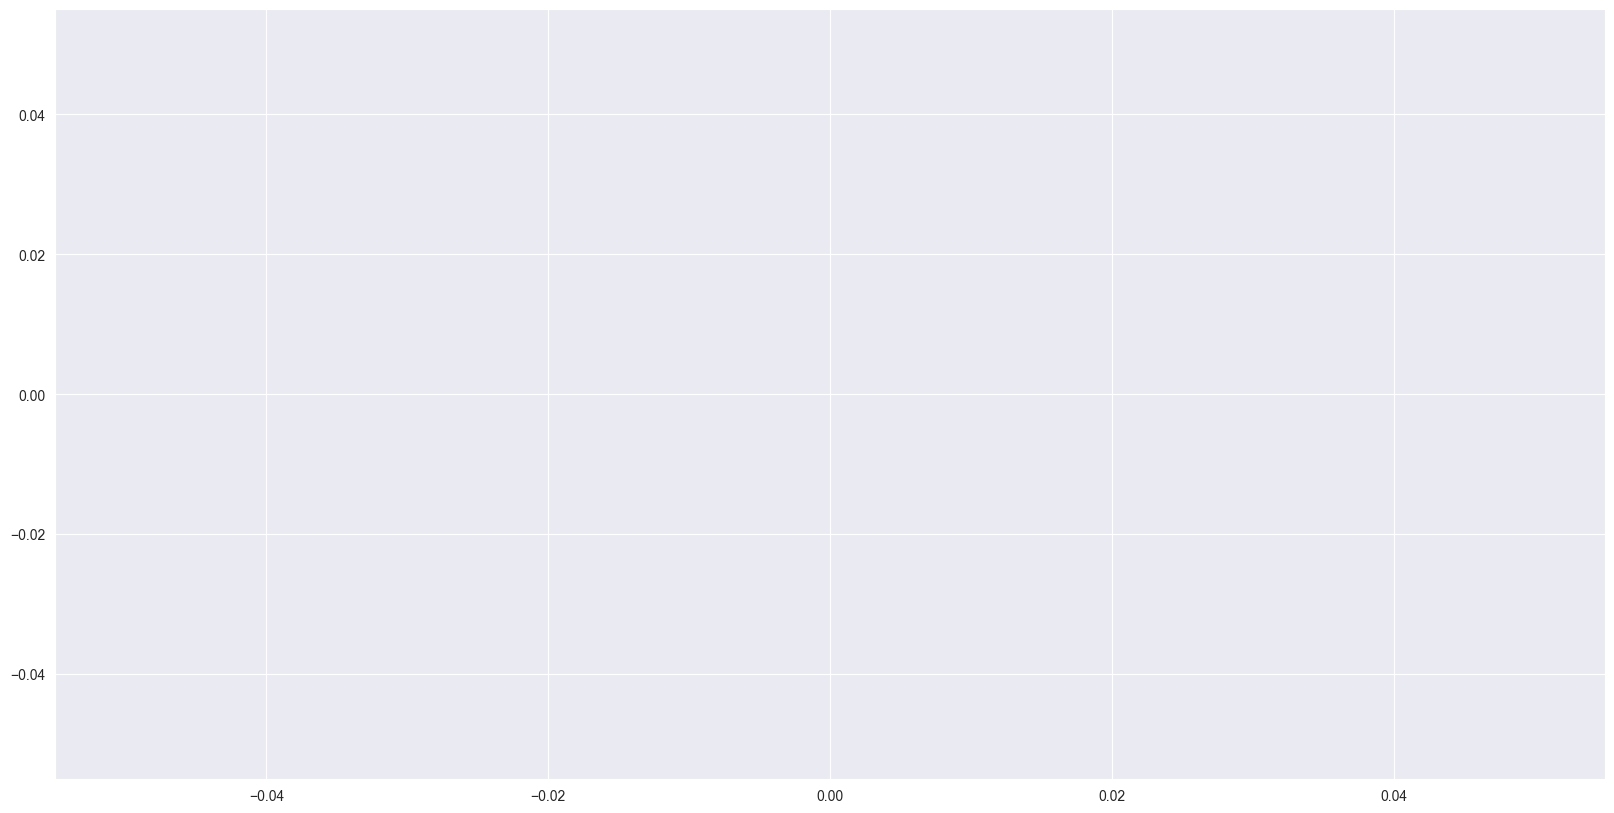

In [6]:
research_info(data_arc, 'об электродах')

**Выводы:** в ходе знакомства с данными об объемах инертного газа были проделаны следующие шаги:
- данные проверены на дубликаты и пропуски;
- изучено распределение данных.
В дальнейшем следует:
- изменить названия столбцов под принятый стиль;
- изменить типы данных на более оптимальные для ускорения рабооты и экономии памяти;
- проверить отрицательную реактивную мощность на выборосы;
- рассчитать количество потребляемой электроэнергии на каждую партию.

### Данные о подаче сыпучих материалов (объём)

Данные о подаче сыпучих материалов (объём)
Количество стобцов: 16
Количество строк: 3129
Дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
1350  1403     NaN     NaN    21.0     NaN     NaN     NaN     NaN     NaN   
2143  2221     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
862    898     NaN     NaN     NaN   115.0     NaN     NaN     NaN     NaN   
458    484     NaN     NaN     NaN   115.0     NaN     NaN     NaN     NaN   
1647  1707     NaN     NaN     NaN    60.0     NaN     NaN     NaN     NaN   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
1350     NaN      NaN      NaN    360.0      NaN    161.0    187.0  
2143     NaN    125.0      NaN      NaN      NaN      NaN      NaN  
862      NaN      NaN      NaN    207.0      NaN    291.0    103.0  
458      NaN      NaN      NaN    253.0      NaN    134.0    224.0  
1647     NaN      NaN      NaN    207.0      NaN    100.0    205.0

key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

Всего значений в таблице 3129, из них пропущено от 323 до 3128 значений, доля пропущенных равна от 10.32% до 99.97% в 15 столбцах.


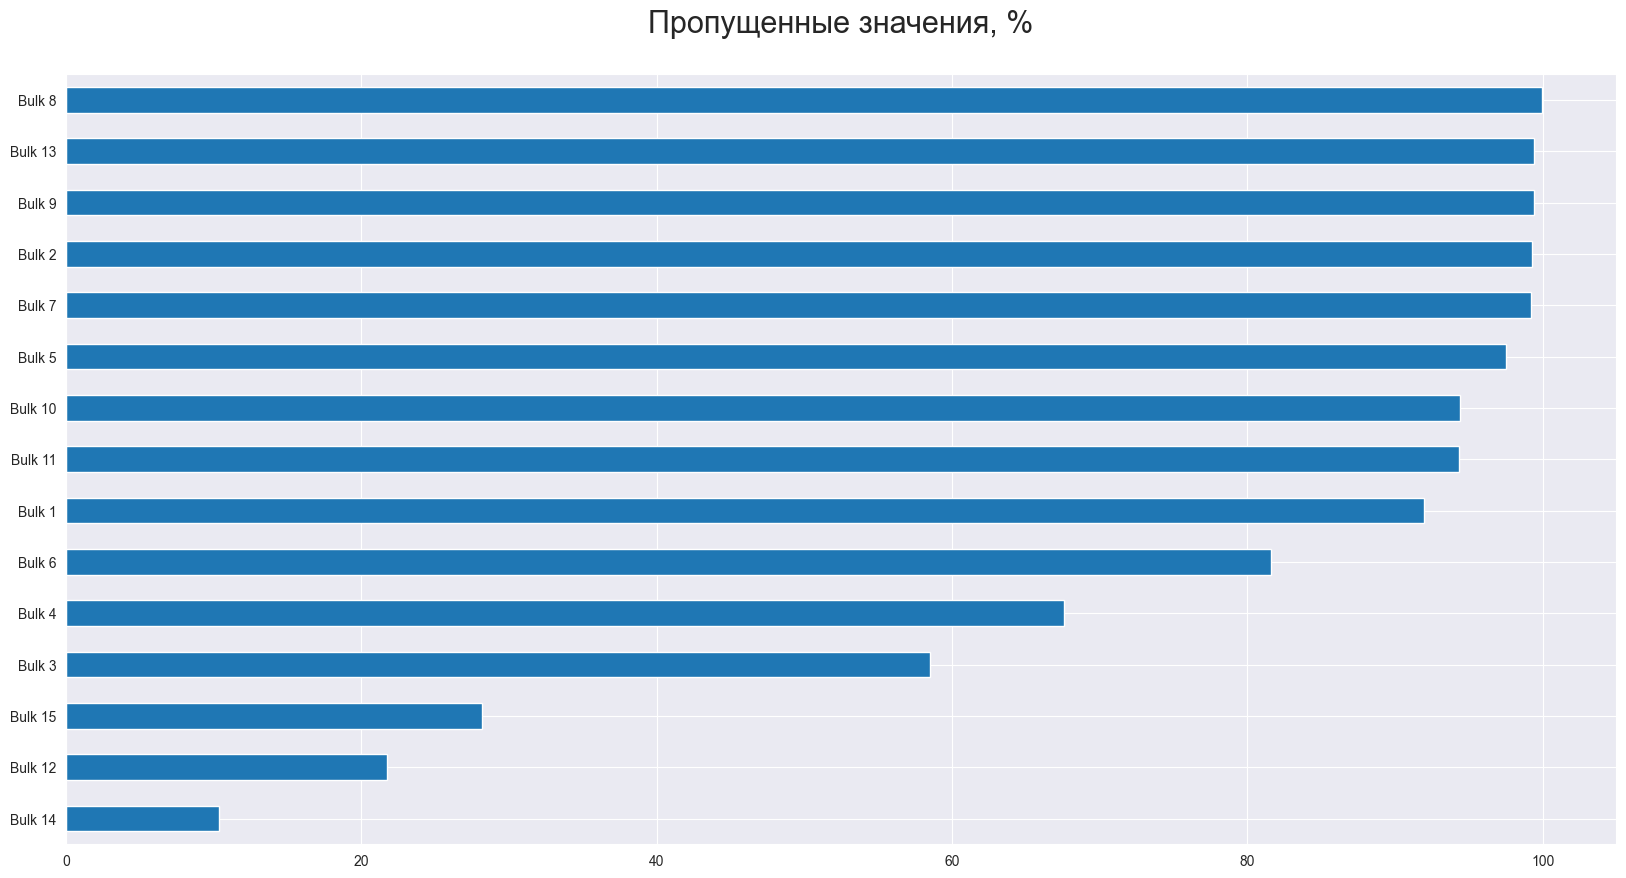

In [7]:
research_info(data_bulk, 'о подаче сыпучих материалов (объём)')

**Выводы:** в ходе знакомства с данными об объемах инертного газа были проделаны следующие шаги:
- данные проверены на дубликаты и пропуски;;
- изучено распределение данных.
В дальнейшем следует:
- изменить названия столбцов под принятый стиль;
- во всех строках есть пропуски, которые связаны с технологическим процессом. Эти пропуски вероятнее всего означают, что данную присадку не добавляют в конкретную партию, а значит пропуски в можно заменить 0.

### Данные о подаче сыпучих материалов (время)

Данные о подаче сыпучих материалов (время)
Количество стобцов: 16
Количество строк: 3129
Дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


key Bulk 1 Bulk 2               Bulk 3               Bulk 4  \
599    629    NaN    NaN                  NaN                  NaN   
1263  1314    NaN    NaN  2019-06-21 22:59:48                  NaN   
492    519    NaN    NaN                  NaN  2019-05-23 08:25:21   
2578  2676    NaN    NaN  2019-08-17 05:36:00                  NaN   
410    436    NaN    NaN                  NaN                  NaN   

                   Bulk 5               Bulk 6 Bulk 7 Bulk 8 Bulk 9 Bulk 10  \
599                   NaN  2019-05-27 08:45:17    NaN    NaN    NaN     NaN   
1263                  NaN                  NaN    NaN    NaN    NaN     NaN   
492                   NaN                  NaN    NaN    NaN    NaN     NaN   
2578  2019-08-17 05:36:00                  NaN    NaN    NaN    NaN     NaN   
410                   NaN                  NaN    NaN    NaN    NaN     NaN   

     Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
599      NaN                  NaN     NaN                  NaN   
1263     NaN  2019-06-21 23:04:37     NaN  2019-06-21 22:59:48   
492      NaN  2019-05-23 08:15:21     NaN  2019-05-23 08:08:42   
2578     NaN                  NaN     NaN  2019-08-17 05:33:02   
410      NaN  2019-05-20 01:48:43     NaN  2019-05-20 01:48:43   

                  Bulk 15  
599                   NaN  
1263  2019-06-21 22:54:53  
492   2019-05-23 08:01:00  
2578                  NaN  
410                   NaN

key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.000000

Всего значений в таблице 3129, из них пропущено от 323 до 3128 значений, доля пропущенных равна от 10.32% до 99.97% в 15 столбцах.


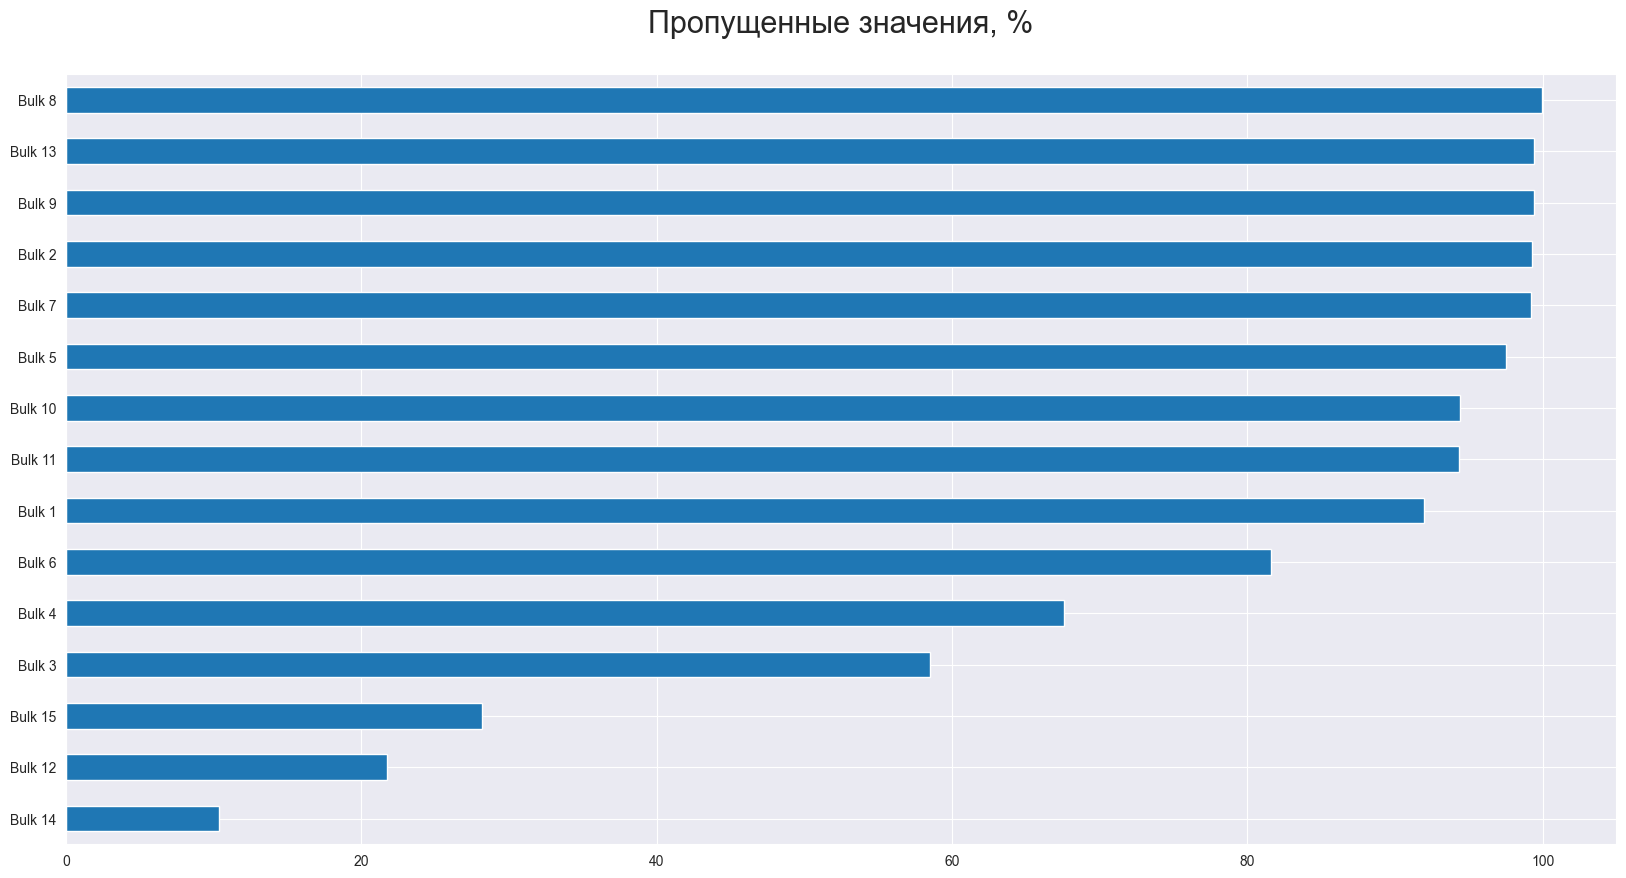

In [8]:
research_info(data_bulk_time, 'о подаче сыпучих материалов (время)')

**Выводы:** в ходе предобработки данных о времени добавления сыпучих материалов были отмечены следующие моменты:
- данные проверены на дубликаты и пропуски;
- изучено распределение данных;
- данные полностью совпадают по наполнению с данными по объему;
- так как заказчиком было отмечено, что время на разных датчиках не синхронизировано, то можно опустить данные о времени загрузки присадок и не использовать эту таблицу в дальнейшем.

### Данные о продувке сплава газом

Данные о продувке сплава газом
Количество стобцов: 2
Количество строк: 3239
Дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


key      Газ 1
3114  3117   5.066467
770    773  10.177886
3182  3185  23.013479
1582  1585  11.091015
1641  1644  13.914998

key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

пропусков не осталось :) 


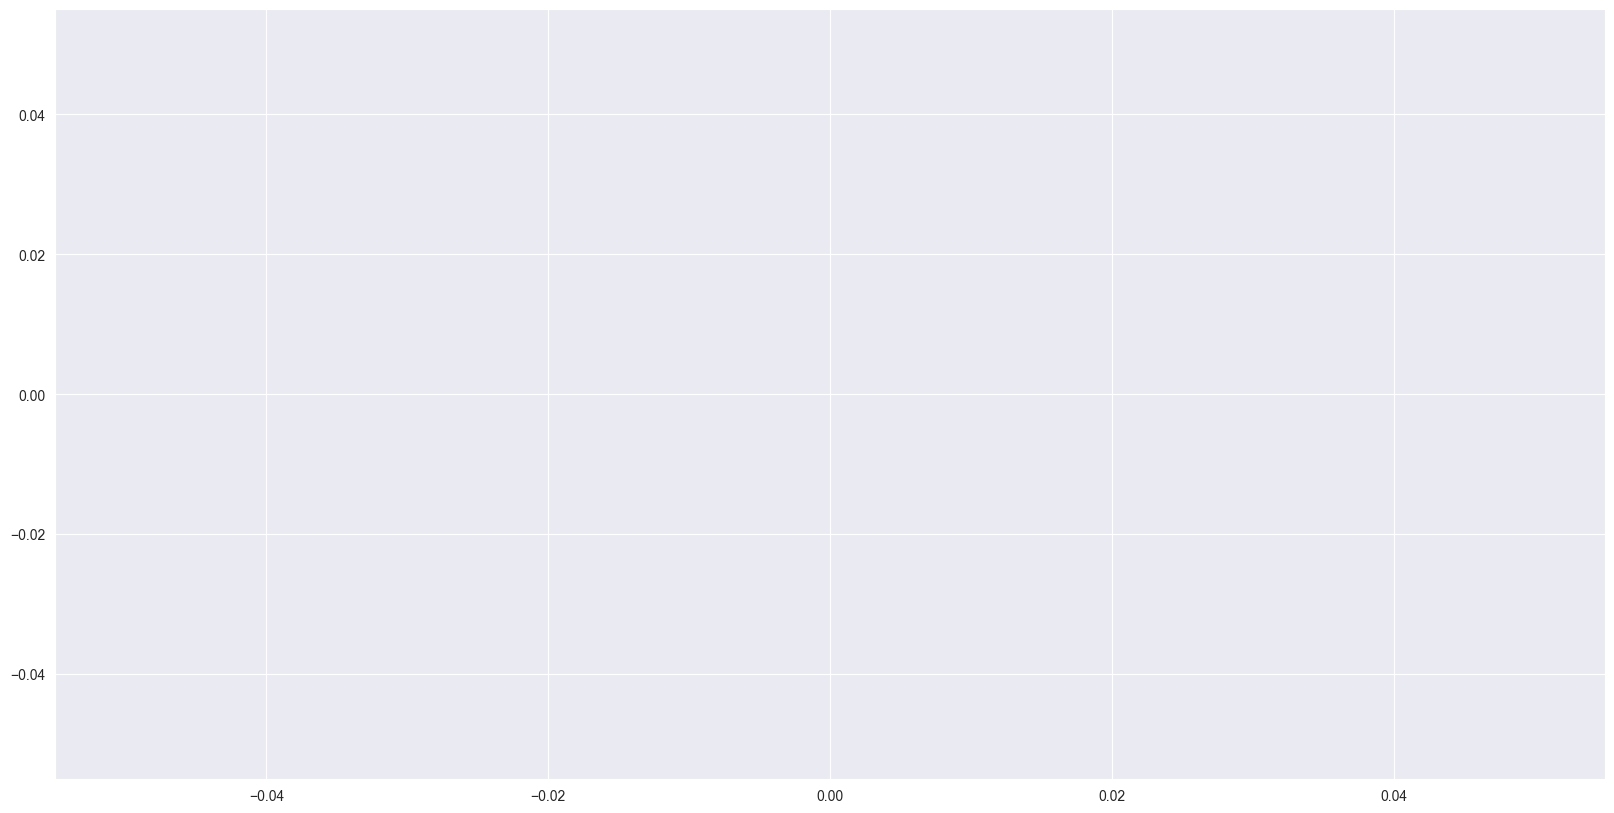

In [9]:
research_info(data_gas, 'о продувке сплава газом')

**Выводы:** в ходе знакомства с данными об объемах инертного газа были проделаны следующие шаги:
- данные проверены на дубликаты и пропуски;
- изучено распределение данных;
В дальнейшем следует:
- изменить названия столбцов под принятый стиль;
- проверить данные на выбросы.

### Данные о результатах измерения температуры

Данные о результатах измерения температуры
Количество стобцов: 3
Количество строк: 18092
Дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


key         Время замера  Температура
5637   1003  2019-06-11 03:50:45       1615.0
9380   1674  2019-07-04 19:42:39       1585.0
11875  2115  2019-07-28 01:58:30       1579.0
13363  2391  2019-08-06 17:30:31       1623.0
990     174  2019-05-10 06:17:07       1571.0

key   Температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000

Всего значений в таблице 18092, из них пропущено от 3427 до 3427 значений, доля пропущенных равна от 18.94% до 18.94% в 1 столбцах.


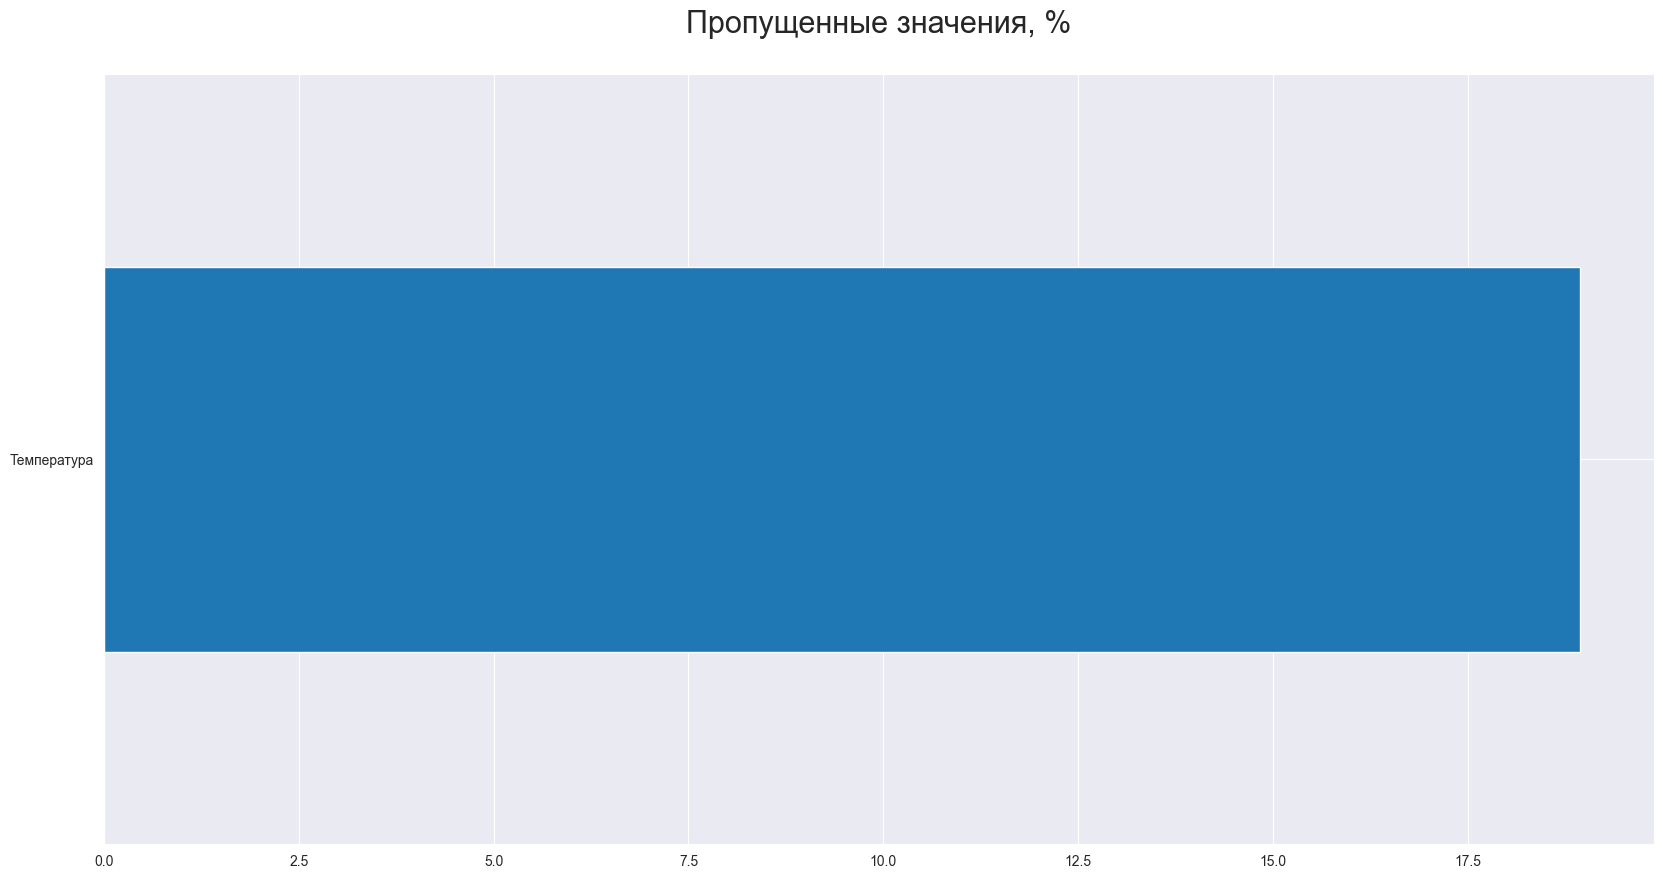

In [10]:
research_info(data_temp, 'о результатах измерения температуры')

**Выводы:** в ходе знакомства с данными о замерах температур:
- данные проверены на дубликаты и пропуски;
- изучено распределение данных;
В дальнейшем следует:
- изменить названия столбцов под принятый стиль;
- для дальнейшей работы данные о температуре будет лучше представить не как временной ряд замеров, а как набор замеров по каждой партии.

### Данные о проволочных материалах (объём)

Данные о проволочных материалах (объём)
Количество стобцов: 10
Количество строк: 3081
Дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


key      Wire 1      Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
1338  1409   77.173202  124.289360     NaN     NaN     NaN     NaN     NaN   
1116  1183   60.091198   90.148239     NaN     NaN     NaN     NaN     NaN   
1836  1926   90.111839         NaN     NaN     NaN     NaN     NaN     NaN   
332    359  114.191993         NaN     NaN     NaN     NaN     NaN     NaN   
2096  2194   36.079678   56.127762     NaN     NaN     NaN     NaN     NaN   

      Wire 8  Wire 9  
1338     NaN     NaN  
1116     NaN     NaN  
1836     NaN     NaN  
332      NaN     NaN  
2096     NaN     NaN

key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

Всего значений в таблице 3081, из них пропущено от 26 до 3080 значений, доля пропущенных равна от 0.84% до 99.97% в 9 столбцах.


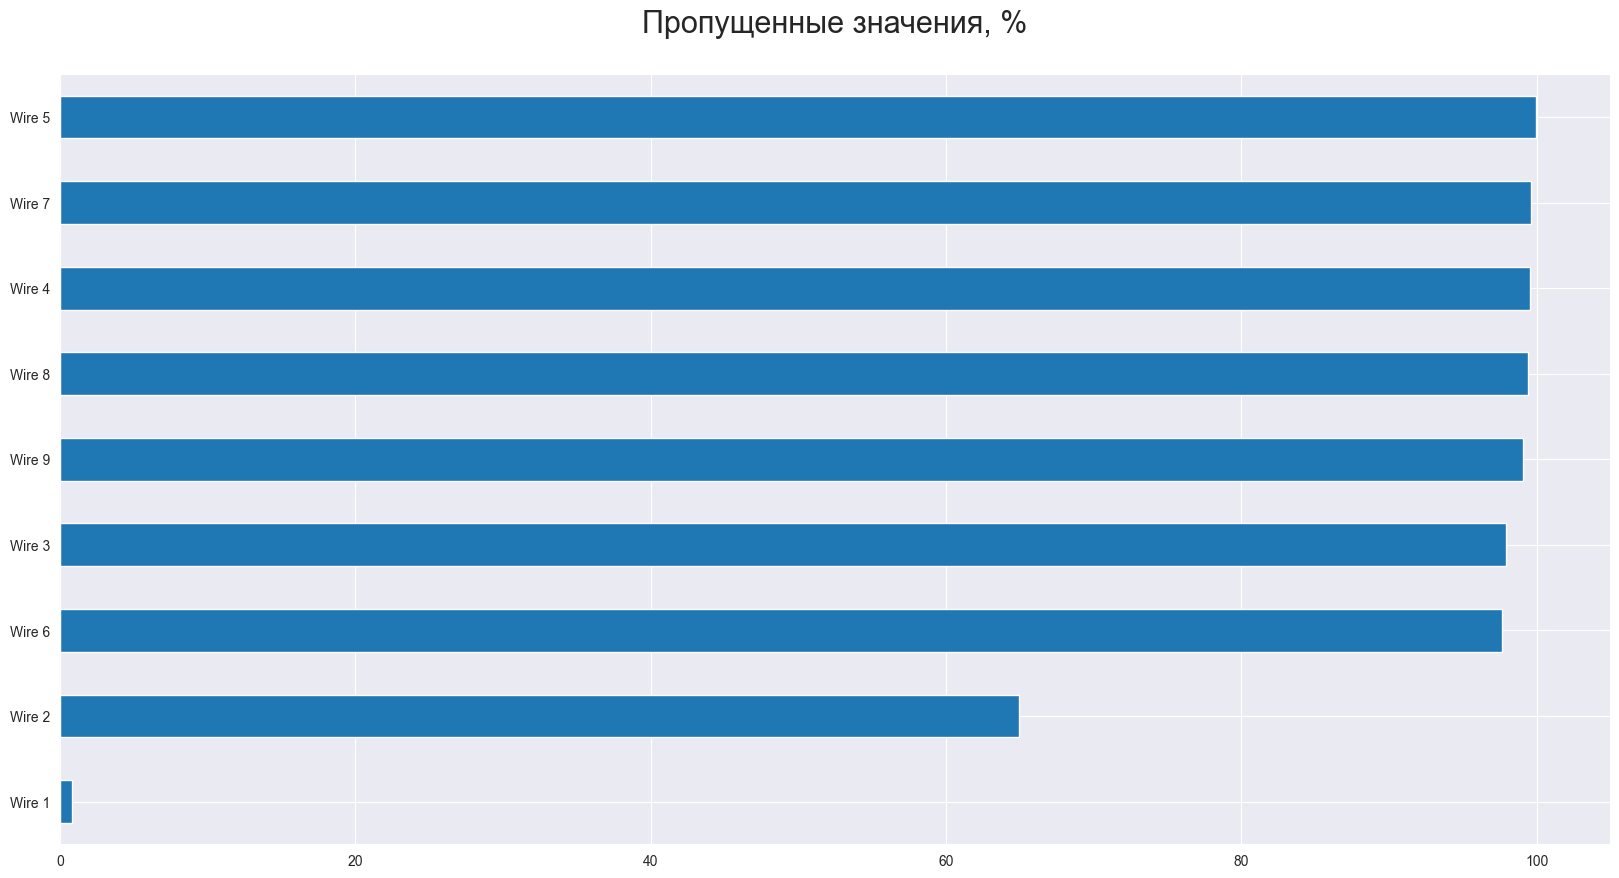

In [11]:
research_info(data_wire, 'о проволочных материалах (объём)')

**Выводы:** в ходе знакомства с данными об объемах проволочных материалов были отмечены следующие моменты:
- данные проверены на дубликаты и пропуски;
- изучено распределение данных.
В дальнейшем следует:
- изменить названия столбцов под принятый стиль;
- удалить данные о незначительно малых примесях.

### Данные о проволочных материалах (время)

Данные о проволочных материалах (время)
Количество стобцов: 10
Количество строк: 3081
Дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5  \
2173  2284  2019-08-02 15:46:46  2019-08-02 15:37:25    NaN    NaN    NaN   
1013  1073  2019-06-13 17:14:53                  NaN    NaN    NaN    NaN   
1446  1518  2019-06-29 14:42:50  2019-06-29 14:39:11    NaN    NaN    NaN   
2001  2098  2019-07-26 22:59:27                  NaN    NaN    NaN    NaN   
2589  2723  2019-08-18 17:16:06                  NaN    NaN    NaN    NaN   

                   Wire 6 Wire 7 Wire 8 Wire 9  
2173                  NaN    NaN    NaN    NaN  
1013                  NaN    NaN    NaN    NaN  
1446                  NaN    NaN    NaN    NaN  
2001                  NaN    NaN    NaN    NaN  
2589  2019-08-18 17:05:42    NaN    NaN    NaN

key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000

Всего значений в таблице 3081, из них пропущено от 26 до 3080 значений, доля пропущенных равна от 0.84% до 99.97% в 9 столбцах.


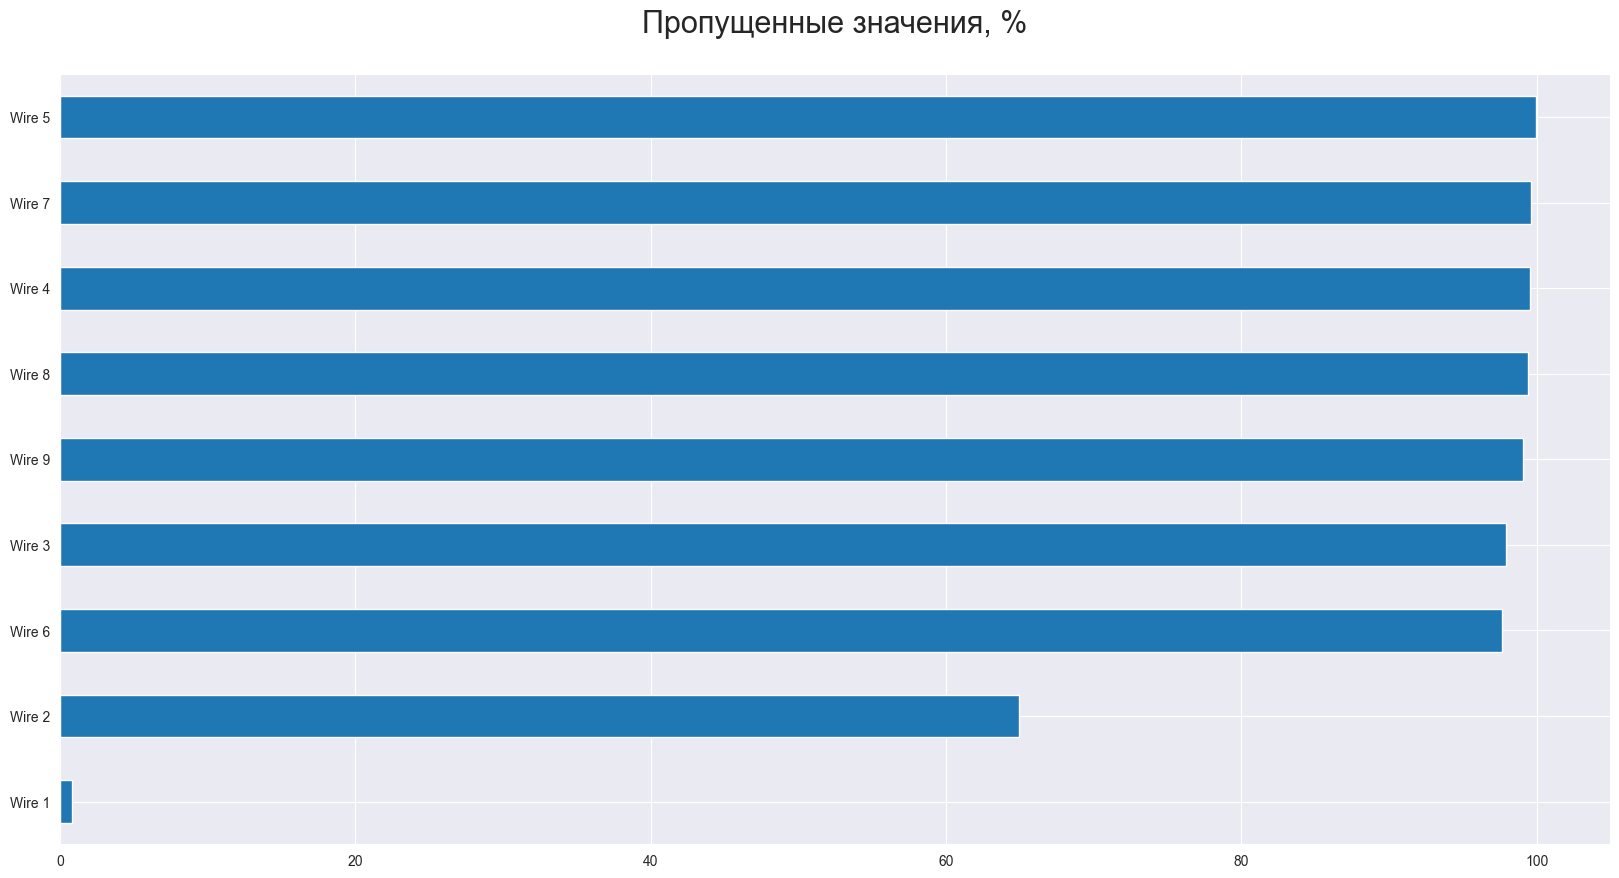

In [12]:
research_info(data_wire_time, 'о проволочных материалах (время)')

**Выводы:** в ходе предобработки данных о времени добавления проволочных материалов были отмечены следующие моменты:
- данные проверены на дубликаты и пропуски;
- изучено распределение данных;
- данные полностью совпадают по наполнению с данными по объему;
- так как заказчиком было отмечено, что время на разных датчиках не синхронизировано, то можно опустить данные о времени загрузки материалов и не использовать эту таблицу в дальнейшем.

### Выводы по ознакомлению с данными и план следующего шага:

**Выводы:** в ходе знакомства с предоставленными заказчиком данными была проделана следующая работа:
- все полученные данные проверены на дубликаты и пропуски;
- определены планы по заполнению пропусков в данных;
- выделены необходимые для дальнейшей работы наборы данных и те датасеты, что не представляют на текущий момент ценности для работы.

Дальнейшая работа по анализу данных и их предобработке будет включать в себя:
- приведение всех таблиц к единому стилю названий столбцов;
- заполнение пропусков в датасетах;
- создание новых признаков из имеющихся данных;
- очистку данных от выбросов;
- создание датасета с полным набором признаков, необходимых для дальнейшего обучения моделей;
- выделение целевого признака;
- разделение данных на обучающую, валидационную и тестовую выборки.

## Шаг 2. Исследовательский анализ и предобработка данных <a class="anchor" id="section2"></a>

### Данные об электродах

Приеведем названия столбцов к единому стилю и оптимизируем данные.

In [13]:
# Переименование столбцов
data_arc.columns = ['key', 'arc_heating_start', 'arc_heating_finish', 'active_power', 'reactive_power']

In [14]:
# Изменение типа данных
data_arc['key'] = pd.to_numeric(data_arc['key'], downcast='integer')
data_arc['arc_heating_start'] = pd.to_datetime(data_arc['arc_heating_start'], format='%Y-%m-%d %H:%M:%S')
data_arc['arc_heating_finish'] = pd.to_datetime(data_arc['arc_heating_finish'], format='%Y-%m-%d %H:%M:%S')
data_arc['active_power'] = pd.to_numeric(data_arc['active_power'], downcast='float')
data_arc['reactive_power'] = pd.to_numeric(data_arc['reactive_power'], downcast='float')

Построим графики распределения мощностей.

In [15]:
px.histogram(data_arc,
             x='active_power',  # количественный признак
             marginal='box',  # дополнительный график: boxplot
             title='Распределение активной мощности')

Распределение активной мощности имеет скошенный в право хвост и выглядит похожим на соответствующее действительности.

Несмотря на то, что реактивная мощность может быть как положительной величиной (если нагрузка имеет активно-индуктивный характер), так и отрицательной (если нагрузка имеет активно-ёмкостный характер), распределение в данном конкретном случае похоже на выброс и стоит проверить этот момент с помощью "ящика с усами".

In [16]:
px.histogram(data_arc,
             x='reactive_power',  # количественный признак
             marginal='box',  # дополнительный график: boxplot
             title='Распределение реактивной мощности')

Действительно, для реактивной мощности есть один очень выделяющийся выброс. Проверим информацию о нем.

In [17]:
data_arc[data_arc['reactive_power'] < 0]

key   arc_heating_start  arc_heating_finish  active_power  \
9780  2116 2019-07-28 02:22:08 2019-07-28 02:23:57      0.705344   

      reactive_power  
9780     -715.479919

Отрицательное значение в данных с реактивной мощностью только одно — это явный выброс. Посмотрим сколько данных мы потеряем, если удалим партию с данным выбросом. Важно отметить, чтобы не было

In [18]:
print('Количество операций в партии: {}'.format(len(data_arc[data_arc['key'] == 2116])))
print('Доля в датафрейме: {:.2%}'.format(len(data_arc[data_arc['key'] == 2116]) / len(data_arc)))

Количество операций в партии: 4
Доля в датафрейме: 0.03%


Потеря данных будет несущественна, а значит можно смело удалять.

In [19]:
data_arc = data_arc[data_arc['key'] != 2116]

Найдем полную мощность. Формула полной мощности: $S = \sqrt{P^{2}+Q^{2}}$, где P — активная , Q — реактивная мощности.


In [20]:
data_arc['full_power'] = (data_arc['active_power'] ** 2 + data_arc['reactive_power'] ** 2) ** 0.5

Посмотрим ещё раз на распределение мощностей.

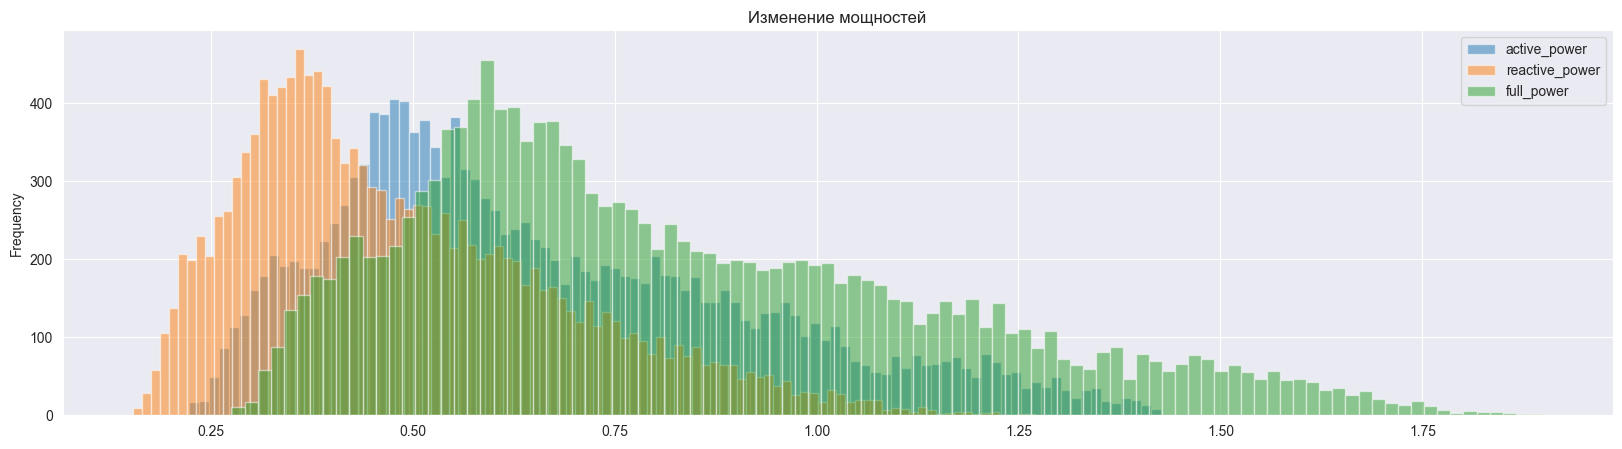

In [21]:
for power in ('active_power', 'reactive_power', 'full_power'):
    data_arc[power].plot(
        kind='hist',
        bins=100,
        grid=True,
        legend=True,
        figsize=(20, 5),
        alpha=0.5,
    ).set(title='Изменение мощностей')

Распределения мощностей похожи между собой.

Чтобы рассчитать энергопотребление на выплавку партии стали, необходимо знать время нагрева для каждой итерации и потребляемую мощность. Для этого найдем время.

In [22]:
data_arc['arc_heating_time'] = (data_arc['arc_heating_finish'] - data_arc['arc_heating_start']).apply(
    lambda x: x.seconds)

Теперь можно найти количество потребляемой энергии на один нагрев по формуле $E =S*t$.

In [23]:
data_arc['electricity_consumption'] = data_arc['full_power'] * data_arc['arc_heating_time']

Исходя из имеющихся данных, разумно будет рассчитать потребление данных не на каждую итерацию, а общее потребление каждой партии.

С помощью данной же таблицы можно посмотреть на распределение количества итераций для каждой партии.

In [24]:
display(data_arc['key'].value_counts().describe())
px.histogram(data_arc,
             x=data_arc['key'].value_counts(),  # количественный признак
             nbins=16,
             marginal='box',  # дополнительный график: boxplot
             title='Количество итераций')

count    3213.000000
mean        4.628696
std         1.608860
min         1.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: key, dtype: float64

В большинстве случаев для получения стали с нужными характеристиками достаточно 4-5 итераций по добавлению примесей, но в редких случаях может быть и больше 10 таких добавлений. Посмотрим насколько редки такие многосоставные рецепты.

In [25]:
print('Всего {} случая из {}, их доля {:.2%}'.format(sum(data_arc['key'].value_counts() > 9), data_arc['key'].nunique(),
                                                     sum(data_arc['key'].value_counts() > 9) / data_arc[
                                                         'key'].nunique()))

Всего 23 случая из 3213, их доля 0.72%


С одной стороны, таких партий со сложносоставным сплавом, где было необходимо делать больше 10 итераций добавления присадок достаточно мало, с другой - они бывают и их необходимо учитывать в производстве, а значит лучше оставить данные в таблице.

Заказчиком было отмечено, что время на разных датчиках не синхронизировано, а значит информация о датах не существенна и может быть удалена.

In [26]:
data_arc = data_arc.drop(axis=1,
                         columns=['arc_heating_start', 'arc_heating_finish'])

In [27]:
data_arc.head(10)

key  active_power  reactive_power  full_power  arc_heating_time  \
0    1      0.305130        0.211253    0.371123               228   
1    1      0.765658        0.477438    0.902319               185   
2    1      0.580313        0.430460    0.722537               172   
3    1      0.518496        0.379979    0.642824               365   
4    1      0.867133        0.643691    1.079934               148   
5    2      0.381124        0.220351    0.440239               137   
6    2      0.261665        0.205527    0.332731               338   
7    2      0.710297        0.484962    0.860064               126   
8    2      0.786322        0.542517    0.955315               210   
9    3      1.101678        0.820856    1.373863               280   

   electricity_consumption  
0                84.616000  
1               166.928985  
2               124.276279  
3               234.630606  
4               159.830267  
5                60.312692  
6               112.463071  
7               108.368053  
8               200.616174  
9               384.681568

In [28]:
# Создадим датасет, сгруппируем по key и агрегируем его по суммам переменных
data_arc_new = data_arc.groupby('key', as_index=False).agg(full_heating_time=('arc_heating_time', 'sum'),
                                                           full_electricity_consumption=(
                                                               'electricity_consumption', 'sum'),
                                                           full_power=(
                                                               'full_power', 'sum'),
                                                           count_iter=('key', 'count')
                                                           )

In [29]:
data_arc_new.head()

key  full_heating_time  full_electricity_consumption  full_power  \
0    1               1098                    770.282136    3.718736   
1    2                811                    481.759989    2.588349   
2    3                655                    722.837644    5.019223   
3    4                741                    683.455623    3.400038   
4    5                869                    512.169926    2.816980   

   count_iter  
0           5  
1           4  
2           5  
3           4  
4           4

**Выводы:** в ходе предобработки данных об электродах были проделаны следующие шаги:
- удалена партия с явными выбросами, а именно с отрицательной мощностью;
- произведены расчеты:
    - полной мощности, потребляемой при нагреве на каждом этапе;
    - затраченного времени на каждый этап выплавки;
    - затраченного времени на каждую партию;
    - количества электроэнергии, потребляемого на каждый этап;
    - количества электроэнергии, потребляемого на каждую партию;
    - количества этапов выплавки каждой партии.

В дальнейшем, при составлении единой таблицы со всеми данными о производстве агрегированные данные принесут больше пользы, чем разрозненные.

### Данные о подаче сыпучих материалов (объём)

Создадим таблицу с агрегированной информацией о подаче сыпучих материалов.

In [30]:
# Группировка данных о подаче сыпучих материалов по key и создание новой таблицы с агрегированными данными
data_bulk_new = data_bulk.melt(id_vars=['key'], value_vars=list(data_bulk.columns[1:]),
                               var_name='bulk_number',
                               value_name='bulk_volume',
                               ignore_index=False).dropna().sort_values(by=['key', 'bulk_number']).groupby('key',
                                                                                                           as_index=False).agg(
    full_bulk_volume=('bulk_volume', 'sum'),
    count_bulk=('key', 'count'))

In [31]:
data_bulk_new.head()

key  full_bulk_volume  count_bulk
0    1             553.0           4
1    2             582.0           4
2    3             544.0           4
3    4             595.0           4
4    5             584.0           4

Заполним пропуски в основной таблице с данными о подаче сыпучих материалов, которые связаны с технологическим процессом. Эти пропуски вероятнее всего означают, что данную присадку не добавляют в конкретную партию, а значит пропуски в можно заменить 0.

In [32]:
data_bulk = data_bulk.fillna(0)

Построим график распределения объемов каждой присадки, суммарно затраченной на производство сплавов.

In [33]:
px.bar(data_bulk.melt(id_vars=['key'], value_vars=list(data_bulk.columns[1:]),
                      var_name='bulk_number',
                      value_name='bulk_volume',
                      ignore_index=False).sort_values(by=['key', 'bulk_number']).groupby('bulk_number').sum(
    'bulk_volume')['bulk_volume'].sort_values(ascending=False),
       title='Распределение использования объемов сыпучих материалов по партиям')

Можно заметить, что присадки номер 1, 2, 5, 7, 8, 9, 10, 11 и 13 используются во много раз меньше, чем остальные. Сохранение этих столбцов в данных не является приоритетом и можно их удалить.

In [34]:
data_bulk = data_bulk.drop(axis=1,
                           columns=['Bulk 1', 'Bulk 2', 'Bulk 5', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11',
                                    'Bulk 13'])

Приведем названия оставшихся столбцов к принятому стилю.

In [35]:
data_bulk = data_bulk.rename(
    columns={'Bulk 3': 'bulk_3', 'Bulk 4': 'bulk_4', 'Bulk 6': 'bulk_6', 'Bulk 12': 'bulk_12', 'Bulk 14': 'bulk_14',
             'Bulk 15': 'bulk_15'})

In [36]:
data_bulk.head()

key  bulk_3  bulk_4  bulk_6  bulk_12  bulk_14  bulk_15
0    1     0.0    43.0     0.0    206.0    150.0    154.0
1    2     0.0    73.0     0.0    206.0    149.0    154.0
2    3     0.0    34.0     0.0    205.0    152.0    153.0
3    4     0.0    81.0     0.0    207.0    153.0    154.0
4    5     0.0    78.0     0.0    203.0    151.0    152.0

**Выводы:** в ходе предобработки данных об объемах сыпучих материалов были проделаны следующие шаги:
- устранены пропуски;
- названия столбцов приведены к единому стилю;
- удалены столбцы с редкими присадками.

### Данные о продувке сплава газом

Перед тем, как смотреть на распределение данных, подправим название колонки 'Газ 1'.

In [37]:
data_gas = data_gas.rename(columns={'Газ 1': 'gas'})

Построим график распределения объема инертного газа, суммарно затраченного на каждую партию.

In [38]:
px.histogram(data_gas,
             x='gas',  # количественный признак
             marginal='box',  # дополнительный график: boxplot
             title='Распределение объема инертного газа')

Можно заметить пять точек, которые отмечают очень большое количество потребляемого газа. Возможно это связано с теми партиями, в которые добавлялось большое количество признаков. Сравним номера партий, чтобы проверить это предположение.

In [39]:
print('Партии с большим количеством итераций {}'.format(set(data_arc_new[data_arc_new['count_iter'] > 12]['key'])))

Партии с большим количеством итераций {322, 2567, 1513, 46, 1689, 2108}


In [40]:
print('Партии с большим объемом используемого газа {}'.format(set(data_gas[data_gas['gas'] > 50]['key'])))

Партии с большим объемом используемого газа {322, 2570, 117, 280, 2110}


Предположение о связи затраченного газа и количества итераций не подтвердилась <s>, а значит это именно выбросы, которые можно удалить.</s>

In [41]:
# data_gas = data_gas[data_gas['gas'] < 50]

In [42]:
data_gas.head()

key        gas
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

**Выводы:** в ходе предобработки данных об объемах инертного газа были проделаны следующие шаги:
- данные проверены на дубликаты и пропуски;
- удалены строки, содержащие выбросы.

### Данные о результатах измерения температуры

Изменим название столбца 'Температура' на соответствующую принятому стилю.

In [43]:
data_temp = data_temp.rename(columns={'Температура': 'temperature', 'Время замера': 'temp_timestamp'})

Так же изменим типы данных для удобной работы с датами и оптимизации памяти.

In [44]:
# Изменение типа данных
data_temp['key'] = pd.to_numeric(data_temp['key'], downcast='integer')
data_temp['temp_timestamp'] = pd.to_datetime(data_temp['temp_timestamp'], format='%Y-%m-%d %H:%M:%S')
data_temp['temperature'] = pd.to_numeric(data_temp['temperature'], downcast='float')

Посмотрим на распределение температур в ходе добавления присадок.

In [45]:
px.histogram(data_temp,
             x='temperature',  # количественный признак
             marginal='box',  # дополнительный график: boxplot
             title='Распределение температур в процессе нагрева стали')

Можно заметить, что на графике присутствуют несколько заметных выбросов с показателями температуры около 1200 градусов, что по словам заказчика является нарушением технологического процесса, и такие партии необходимо удалить.

In [46]:
set(data_temp[data_temp['temperature'] < 1500]['key'])

{867, 1214, 1619, 2052, 2561}

In [47]:
data_temp = data_temp.query('key not in [867, 1214, 1619, 2052, 2561]')

Данные имеют не самую удобную структуру для дальнейшей работы, поэтому логичнее преобразовать таблицу со строками для каждой партии, для этого сгруппируем данные по ключам, создав из колонки temp_timestamp две даты — время самого первого и самого последнего измерения температуры, а из колонки temperature — столбцы с первой и последней температурой.

In [48]:
# Группировка данных о результатах измерения температуры
data_temp_new = pd.concat([data_temp.groupby(by='key', axis=0).agg({'temp_timestamp': min,
                                                                    'temperature': 'first'}),
                           data_temp.groupby(by='key', axis=0).agg({'temp_timestamp': max,
                                                                    'temperature': 'last'})
                           ], axis=1)
data_temp_new.columns = ['temp_timestamp_start', 'temperature_start', 'temp_timestamp_finish', 'temperature_finish']

Проверим есть ли в полученной таблице строки, где первое измерение равно последнему.

In [49]:
(data_temp_new[data_temp_new['temperature_start'] == data_temp_new['temperature_finish']]).count()

temp_timestamp_start     782
temperature_start        782
temp_timestamp_finish    782
temperature_finish       782
dtype: int64

In [50]:
data_temp_new[data_temp_new['temperature_start'] == data_temp_new['temperature_finish']].head()

temp_timestamp_start  temperature_start temp_timestamp_finish  \
key                                                                 
63   2019-05-05 22:04:48             1580.0   2019-05-05 22:36:23   
195  2019-05-11 00:01:36             1583.0   2019-05-11 00:01:36   
197  2019-05-11 02:36:25             1582.0   2019-05-11 02:49:49   
262  2019-05-13 16:26:11             1596.0   2019-05-13 17:24:48   
279  2019-05-14 10:13:01             1603.0   2019-05-14 10:13:01   

     temperature_finish  
key                      
63               1580.0  
195              1583.0  
197              1582.0  
262              1596.0  
279              1603.0

Такие строки есть, в масштабе набора данных их немного, лучше избавиться от них во избежание утечки данных при разделении на выборки.

In [51]:
data_temp_new = data_temp_new[data_temp_new['temperature_start'] != data_temp_new['temperature_finish']]
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2429 entries, 1 to 2499
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   temp_timestamp_start   2429 non-null   datetime64[ns]
 1   temperature_start      2429 non-null   float32       
 2   temp_timestamp_finish  2429 non-null   datetime64[ns]
 3   temperature_finish     2429 non-null   float32       
dtypes: datetime64[ns](2), float32(2)
memory usage: 75.9 KB


Добавим информацию о времени, суммарно потраченному на нагрев стали. В дальнейшем сравним эти записи с данными, полученными на таблице с электродами.

In [52]:
data_temp_new['temp_heating_time'] = (
        data_temp_new['temp_timestamp_finish'] - data_temp_new['temp_timestamp_start']).apply(
    lambda x: x.seconds)

Вспоминая информацию заказчика об отсутствии синхронизации между датчиками, можно удалить информацию о датах.

In [53]:
data_temp_new = data_temp_new.drop(axis=1, columns=['temp_timestamp_start', 'temp_timestamp_finish'])

In [54]:
print('Количество пропусков в начальных температурах {}'.format(sum(data_temp_new['temperature_start'].isna())))
px.histogram(data_temp_new,
             x='temperature_start',  # количественный признак
             marginal='box',  # дополнительный график: boxplot
             title='Распределение начальных температур в процессе нагрева стали')

Количество пропусков в начальных температурах 0


In [55]:
print('Количество пропусков в финальных температурах {}'.format(sum(data_temp_new['temperature_finish'].isna())))
px.histogram(data_temp_new,
             x='temperature_finish',  # количественный признак
             marginal='box',  # дополнительный график: boxplot
             title='Распределение финальных температур в процессе нагрева стали')

Количество пропусков в финальных температурах 0


In [56]:
data_temp_new.head()

temperature_start  temperature_finish  temp_heating_time
key                                                          
1               1571.0              1613.0               1714
2               1581.0              1602.0               1265
3               1596.0              1599.0               1753
4               1601.0              1625.0               1220
5               1576.0              1602.0               1536

**Выводы:** в ходе предобработки данных о замерах температур:
- данные проверены на дубликаты и пропуски;
- создана новая таблица с начальной и искомой финальной температурами.

### Данные о проволочных материалах (объём)

Создадим таблицу с агрегированной информацией о подаче проволочных материалов.

In [57]:
# Группировка данных о подаче проволочных материалов по key и создание новой таблицы с агрегированными данными
data_wire_new = data_wire.melt(id_vars=['key'], value_vars=list(data_wire.columns[1:]),
                               var_name='wire_number',
                               value_name='wire_volume',
                               ignore_index=False).dropna().sort_values(by=['key', 'wire_number']).groupby('key',
                                                                                                           as_index=False).agg(
    full_wire_volume=('wire_volume', 'sum'),
    count_wire=('key', 'count'))
data_wire_new.head()

key  full_wire_volume  count_wire
0    1         60.059998           1
1    2         96.052315           1
2    3         91.160157           1
3    4         89.063515           1
4    5         98.352796           2

Во всех строках есть пропуски, которые связаны с технологическим процессом. Эти пропуски вероятнее всего означают, что данную проволоку не добавляют в конкретную партию, а значит пропуски можно заменить 0.

In [58]:
data_wire = data_wire.fillna(0)

Построим график распределения объемов каждой присадки, суммарно затраченной на производство сплавов.

In [59]:
px.bar(data_wire.melt(id_vars=['key'], value_vars=list(data_wire.columns[1:]),
                      var_name='wire_number',
                      value_name='wire_volume',
                      ignore_index=False).sort_values(by=['key', 'wire_number']).groupby('wire_number').sum(
    'wire_volume')['wire_volume'].sort_values(ascending=False),
       title='Распределение использования объемов проволочных материалов по партиям')

Можно заметить, что проволочные материалы номер 4, 5, 7, 8 и 9 используются во много раз меньше, чем остальные. Сохранение этих столбцов в данных не является приоритетом и можно их удалить.

In [60]:
data_wire = data_wire.drop(axis=1,
                           columns=['Wire 4', 'Wire 5', 'Wire 7', 'Wire 8', 'Wire 9'])

Приведем названия оставшихся столбцов к принятому стилю.

In [61]:
data_wire = data_wire.rename(
    columns={'Wire 1': 'wire_1', 'Wire 2': 'wire_2', 'Wire 3': 'wire_3', 'Wire 6': 'wire_6'})

In [62]:
data_wire.head()

key     wire_1   wire_2  wire_3  wire_6
0    1  60.059998  0.00000     0.0     0.0
1    2  96.052315  0.00000     0.0     0.0
2    3  91.160157  0.00000     0.0     0.0
3    4  89.063515  0.00000     0.0     0.0
4    5  89.238236  9.11456     0.0     0.0

**Выводы:** в ходе предобработки данных об объемах проволочных материалов были проделаны следующие шаги:
- данные проверены на дубликаты и пропуски;
- удалены столбцы с редкими добавками.

### Подготовка данных для обучения

Создадим общую таблицу, в которой будут содержаться все признаки, отмеченные ранее как важные.

In [63]:
full_data = (
    data_arc_new.merge(data_temp_new, how='inner', on='key').merge(data_gas, how='inner', on='key').merge(data_bulk,
                                                                                                          how='inner',
                                                                                                          on='key').merge(
        data_bulk_new, how='inner', on='key').merge(data_wire, how='inner', on='key').merge(data_wire_new, how='inner',
                                                                                            on='key'))

Ключи, по которым выполнено соединение и обозначающие номера партии, не несут в себе важной информации именно по технологическому процессу, а значит их можно удалить.

In [64]:
full_data = full_data.drop(axis=1, columns=['key'])

In [65]:
full_data.head(10)

full_heating_time  full_electricity_consumption  full_power  count_iter  \
0               1098                    770.282136    3.718736           5   
1                811                    481.759989    2.588349           4   
2                655                    722.837644    5.019223           5   
3                741                    683.455623    3.400038           4   
4                869                    512.169926    2.816980           4   
5                952                    839.231371    3.313075           4   
6                673                    613.576988    3.283913           4   
7                913                    619.129549    3.405956           4   
8                625                    570.113667    4.335261           5   
9                825                    533.482050    3.791005           6   

   temperature_start  temperature_finish  temp_heating_time        gas  \
0             1571.0              1613.0               1714  29.749986   
1             1581.0              1602.0               1265  12.555561   
2             1596.0              1599.0               1753  28.554793   
3             1601.0              1625.0               1220  18.841219   
4             1576.0              1602.0               1536   5.413692   
5             1543.0              1596.0               1497  11.273392   
6             1586.0              1599.0               1744   9.836267   
7             1577.0              1598.0               1615  15.171553   
8             1587.0              1592.0               1811   8.216623   
9             1574.0              1593.0               1551   6.529891   

   bulk_3  bulk_4  ...  bulk_14  bulk_15  full_bulk_volume  count_bulk  \
0     0.0    43.0  ...    150.0    154.0             553.0           4   
1     0.0    73.0  ...    149.0    154.0             582.0           4   
2     0.0    34.0  ...    152.0    153.0             544.0           4   
3     0.0    81.0  ...    153.0    154.0             595.0           4   
4     0.0    78.0  ...    151.0    152.0             584.0           4   
5     0.0   117.0  ...    201.0    154.0             676.0           4   
6     0.0   117.0  ...    152.0    154.0             627.0           4   
7     0.0    99.0  ...    252.0    153.0             914.0           4   
8     0.0   117.0  ...     99.0    203.0             526.0           4   
9     0.0     0.0  ...    102.0    204.0             509.0           3   

       wire_1     wire_2  wire_3  wire_6  full_wire_volume  count_wire  
0   60.059998   0.000000     0.0     0.0         60.059998           1  
1   96.052315   0.000000     0.0     0.0         96.052315           1  
2   91.160157   0.000000     0.0     0.0         91.160157           1  
3   89.063515   0.000000     0.0     0.0         89.063515           1  
4   89.238236   9.114560     0.0     0.0         98.352796           2  
5   99.109917   9.114560     0.0     0.0        108.224477           2  
6   98.061600   0.000000     0.0     0.0         98.061600           1  
7  155.282394   0.000000     0.0     0.0        155.282394           1  
8  113.393279   9.143681     0.0     0.0        122.536960           2  
9   81.244796  12.376000     0.0     0.0         93.620796           2  

[10 rows x 22 columns]

Данные собраны в единую таблицу, а значит в изначальных и дополнительно созданных таблицах больше нет необходимости и можно удалить их из памяти.

In [66]:
df_to_del = [data_arc, data_arc_new, data_bulk, data_bulk_time, data_bulk_new, data_gas, data_temp, data_temp_new,
             data_wire,
             data_wire_time, data_wire_new]
for df in df_to_del:
    del df

gc.collect()

350

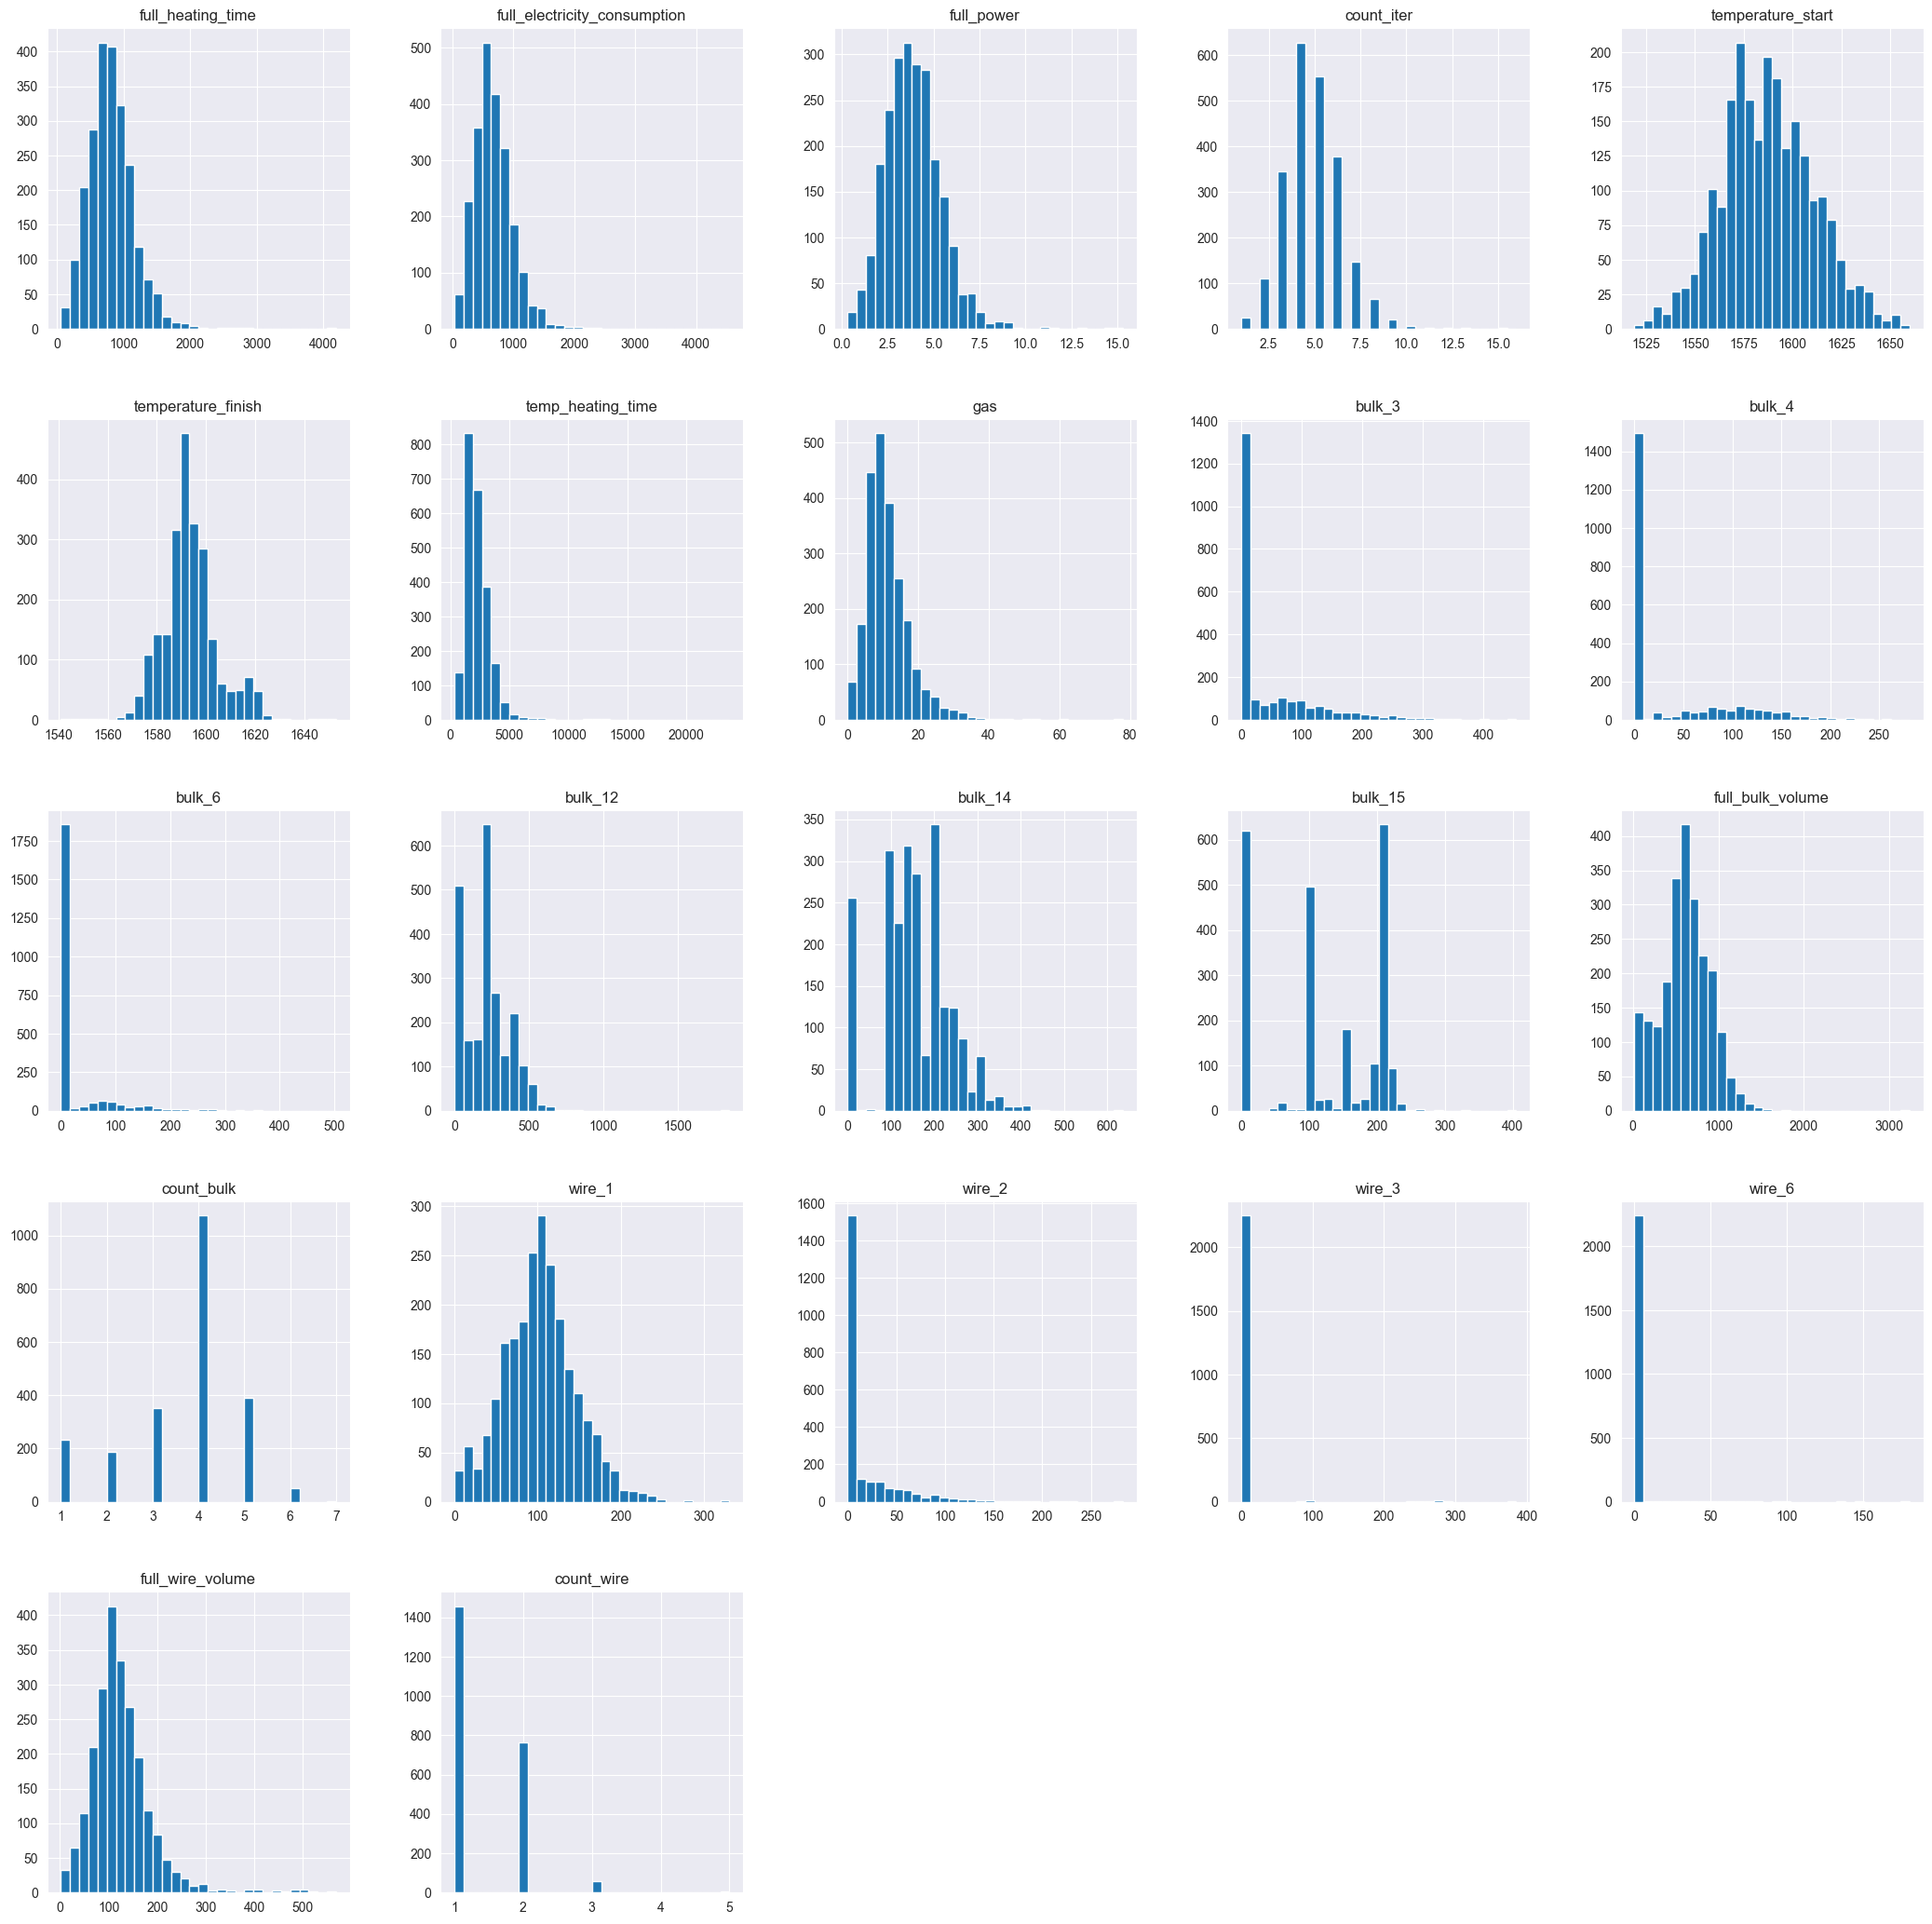

In [67]:
full_data.hist(figsize=(26, 26), bins=30)
plt.show()

Посмотрим на корреляцию признаков в полученной таблице.

<AxesSubplot:>

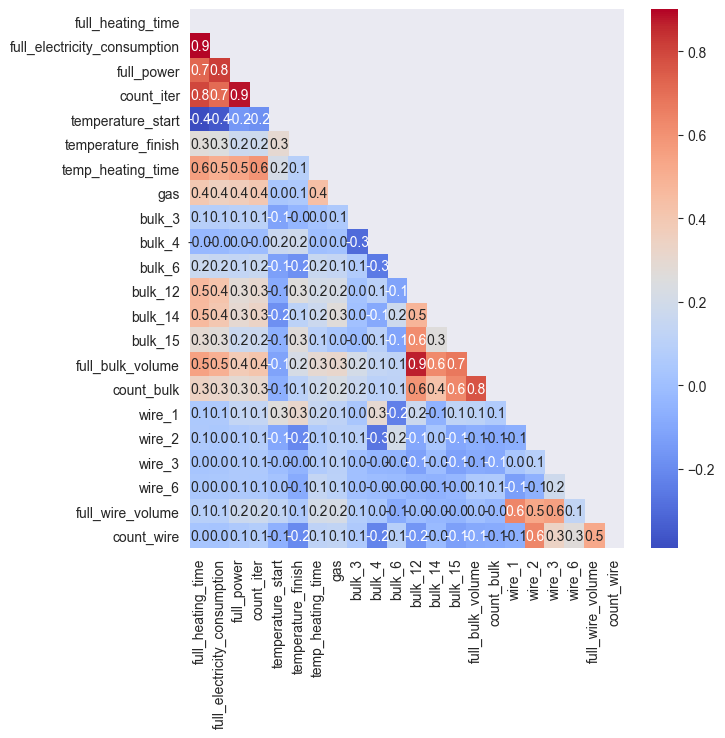

In [68]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(full_data.corr(), mask=np.triu(np.ones_like(full_data.corr())), annot=True, fmt='.1f', cmap='coolwarm')

Можно заметить что данные о времени, затраченном на нагрев, сильно коррелируют с затраченной электроэнергией и количеством итераций, что достаточно логично. А значит, данные о затраченном времени необходимо удалить.

Ключевая метрика финальной температуры заметно реагирует со стартовой температурой, но такая корреляция не является поводом убирать данные.

In [69]:
full_data = full_data.drop(axis=1, columns=['full_heating_time', 'count_iter'])

In [70]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2288 entries, 0 to 2287
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   full_electricity_consumption  2288 non-null   float64
 1   full_power                    2288 non-null   float32
 2   temperature_start             2288 non-null   float32
 3   temperature_finish            2288 non-null   float32
 4   temp_heating_time             2288 non-null   int64  
 5   gas                           2288 non-null   float64
 6   bulk_3                        2288 non-null   float64
 7   bulk_4                        2288 non-null   float64
 8   bulk_6                        2288 non-null   float64
 9   bulk_12                       2288 non-null   float64
 10  bulk_14                       2288 non-null   float64
 11  bulk_15                       2288 non-null   float64
 12  full_bulk_volume              2288 non-null   float64
 13  cou

Посмотрим на корреляцию разных признаков с целевым.

Text(0.5, 1.0, 'Корреляция числовых признаков с температурой')

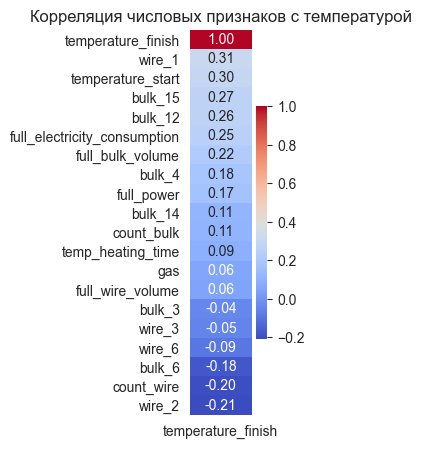

In [71]:
# матрица корреляции
fig, ax = plt.subplots(figsize=(1, 5))
sns.heatmap(full_data.corr()[['temperature_finish']].sort_values(by=['temperature_finish'], ascending=False),
            annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
plt.title('Корреляция числовых признаков с температурой')

Подготовленные данные перед обучением моделей необходимо поделить на обучающую и тестовую выборки и выделить целевой признак.

In [72]:
features = full_data.drop('temperature_finish', axis=1)
target = full_data['temperature_finish']

In [73]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=RAND)

In [74]:
print('Доля обучающей выборки от основного датасета {:.0%}, доля тестовой выборки от основного датасета {:.0%}'.format(
    len(target_train) / len(target), len(target_test) / len(target)))

Доля обучающей выборки от основного датасета 75%, доля тестовой выборки от основного датасета 25%


### Выводы по исследовательскому анализу и предобработке данных и план следующего шага:

**Выводы:** в ходе предобработки данных была проделана следующая работа:
- все таблицы приведены к единому стилю названий столбцов;
- заполнены пропуски в таблицах;
- созданы новые признаки из имеющихся данных;
- данных очищены от выбросов;
- создан датасет с полным набором признаков, необходимых для дальнейшего обучения моделей;
- выделен целевой признак;
- данные разбиты на обучающую, валидационную и тестовую выборки.

Дальнейшая работа с моделями будет включать в себя:
- создание функции для оценки качества моделей;
- с помощью StandardScaler приведение данных к одинаковому масштабу;
- создание предсказания модели LinearRegressor;
- создание предсказания модели RandomForestRegressor;
- создание предсказания модели CatBoostRegressor;
- создание предсказания модели LGBMRegressor;
- создание предсказания модели DummyRegressor;
- сравнение работы моделей и выбор лучшую;
- анализ работы лучшей модели на тестовых данных.

## Шаг 3. Работа с моделями <a class="anchor" id="section3"></a>

Создадим функции, которые позволят сравнить в конце все модели и следить за качеством по ходу работы.

In [75]:
# Генерация таблицы с метриками
def get_metrics(y_test: np.ndarray = None,
                y_pred: np.ndarray = None,
                name: str = None,
                mae: float = None,
                r2score: float = None):
    df_metrics = pd.DataFrame()
    df_metrics['model'] = [name]
    if mae is not None:
        df_metrics['MAE'] = mae
        df_metrics['R2 score'] = r2score
    else:
        df_metrics['MAE'] = mean_absolute_error(y_test, y_pred)
        df_metrics['R2 score'] = r2_score(y_test, y_pred)
    df_metrics['Is good'] = df_metrics['MAE'] < 6.8

    return df_metrics

In [76]:
def grid_search_cv(model, X_train, Y_train, parameters):
    grid = GridSearchCV(estimator=model, param_grid=parameters, cv=5, scoring='neg_mean_absolute_error',
                        n_jobs=-1, error_score='raise')

    grid.fit(X_train, Y_train)
    mae = grid.best_score_ * -1
    r2score = cross_val_score(model, X_train, Y_train, cv=5, scoring="r2").mean()
    best_params = grid.best_params_
    best_estimator = grid.best_estimator_

    return mae, r2score, best_params, best_estimator

Выберем следующие регрессоры для обучения модели:
- LinearRegression;
- DecisionTreeRegressor;
- RandomForestRegressor;
- CatBoostRegressor;
- LGBMRegressor;
- DummyRegressor.

В качестве метрики для всех моделей будем использовать MAE, как было указано заказчиком.

In [77]:
numeric_columns = features.columns.tolist()
transformers_list = [('scale', StandardScaler(), numeric_columns)]

column_transformer = ColumnTransformer(transformers_list)

### 3.1 LinearRegression

In [78]:
lr_pipe = Pipeline([('columnTransformer', column_transformer),
                    ('lr', LinearRegression())])

lr_mae = cross_val_score(lr_pipe, features_train, target_train, cv=5, scoring='neg_mean_absolute_error').mean() * -1
lr_r2_score = cross_val_score(lr_pipe, features_train, target_train, cv=5, scoring="r2").mean()

In [79]:
metrics = get_metrics(name='LinearRegression', mae=lr_mae, r2score=lr_r2_score)

### 3.2 DecisionTreeRegressor

In [80]:
dt_pipe = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=RAND))
dt_parameters = {'decisiontreeregressor__max_depth': list(range(1, 51))}

dt_mae, dt_r2score, dt_best_params, dt_best_estimator = grid_search_cv(dt_pipe, features_train, target_train,
                                                                       dt_parameters)

In [81]:
metrics = metrics.append(
    get_metrics(name='DecisionTreeRegressor', mae=dt_mae, r2score=dt_r2score))

### 3.3 RandomForestRegressor


In [82]:
rf_pipe = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=RAND))

rf_parameters = {'randomforestregressor__max_depth': list(range(50, 250, 50)),
                 'randomforestregressor__n_estimators': list(range(50, 550, 50))}

rf_mae, rf_r2score, rf_best_params, rf_best_estimator = grid_search_cv(rf_pipe, features_train, target_train,
                                                                       rf_parameters)

In [83]:
metrics = metrics.append(
    get_metrics(name='RandomForestRegressor', mae=rf_mae, r2score=rf_r2score))

### 3.4 LGBMRegressor

In [84]:
lgb = make_pipeline(StandardScaler(), LGBMRegressor(random_state=RAND, objective='mae'))

lgb_parameters = {'lgbmregressor__num_leaves': list(range(50, 301, 50)),
                  'lgbmregressor__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]
                  }

lgb_mae, lgb_r2score, lgb_best_params, lgb_best_estimator = grid_search_cv(lgb, features_train, target_train,
                                                                           lgb_parameters)

In [85]:
metrics = metrics.append(
    get_metrics(name='LGBMRegressor', mae=lgb_mae, r2score=lgb_r2score))

### 3.5 CatBoostRegressor

In [86]:
cb = make_pipeline(StandardScaler(), CatBoostRegressor(random_seed=RAND,
                                                       loss_function='MAE',
                                                       eval_metric='MAE',
                                                       allow_writing_files=False,
                                                       verbose=False))

cb_parameters = {'catboostregressor__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
                 'catboostregressor__iterations': list(range(50, 550, 50))
                 }

cb_mae, cb_r2score, cb_best_params, cb_best_estimator = grid_search_cv(cb, features_train, target_train, cb_parameters)

In [87]:
metrics = metrics.append(
    get_metrics(name='CatBoostRegressor', mae=cb_mae, r2score=cb_r2score))

### 3.6 DummyRegressor

In [88]:
dr_pipe = Pipeline([('columnTransformer', column_transformer),
                    ('dr', DummyRegressor())])

dr_mae = cross_val_score(dr_pipe, features_train, target_train, cv=5, scoring='neg_mean_absolute_error').mean() * -1
dr_r2_score = cross_val_score(dr_pipe, features_train, target_train, cv=5, scoring="r2").mean()

In [89]:
metrics = metrics.append(get_metrics(name='DummyRegressor', mae=dr_mae, r2score=dr_r2_score))

**Выводы:**
- модели обучены;
- предсказания составлены;
- параметры качества моделей занесены в таблицу.

### Оценка качества моделей <a class="anchor" id="section3"></a>

Выведем таблицу с метриками и выберем лучшую модель по совокупности параметров.

In [90]:
results = pd.DataFrame(metrics)
results.sort_values('MAE')

model       MAE  R2 score  Is good
0          LGBMRegressor  6.447655  0.344807     True
0      CatBoostRegressor  6.508661  0.348266     True
0  RandomForestRegressor  6.563230  0.353582     True
0       LinearRegression  6.597467  0.388263     True
0  DecisionTreeRegressor  7.563656 -0.308191    False
0         DummyRegressor  8.085420 -0.003574    False

Сделаем выводы о качестве работы моделей машинного обучения на основе полученной таблицы.

R2 оценивает, насколько хорошо регрессионная модель соответствует фактическим данным. Другими словами, это мера общей точности модели. У всех моделей R-квадрат сильно меньше 0.5, а значит можно сказать, что ни одна из моделей не отражает точно реальное положение вещей.

- `CatBoostRegressor` - модель показала лучшее значение ключевой метрики, ошибка в 6,44 градуса на кроссвалидации является допустимой, что дает возможность использовать её в дальнейшей работе, показатель R2 один из самых высоких среди полученных моделей, что так же является плюсом;
- `LGBMRegressor` - модель прошла по ключевой метрике, что давало бы возможность использовать её в дальнейшей работе, однако есть модель с лучшими показателями;
- `LinearRegression` - модель прошла по ключевой метрике, что давало бы возможность использовать её в дальнейшей работе, однако есть модель с лучшими показателями;
- `RandomForestRegressor` - модель прошла по ключевой метрике, что давало бы возможность использовать её в дальнейшей работе, однако есть модель с лучшими показателями;
- `DecisionTreeRegressor` - модель не прошла по ключевой метрике на кросс-валидации, что не дает возможности использовать её в дальнейшей работе;
- `DummyRegressor` - константная модель использовалась для проверки созданных моделей на адекватность.

In [91]:
target_pred_cb = cb_best_estimator.predict(features_test)

get_metrics(target_test, target_pred_cb, 'CatBoostRegressor')

model       MAE  R2 score  Is good
0  CatBoostRegressor  6.511743  0.362581     True

In [92]:
print('Параметры лучшей модели: ', cb_best_params)

Параметры лучшей модели:  {'catboostregressor__iterations': 200, 'catboostregressor__learning_rate': 0.1}


**Выводы:**
Исходя из совокупности требований заказчика, я бы рекомендовала бы взять в работу `CatBoostRegressor`, которая благодаря подбору лучших параметров выдает достаточно хорошие показатели в метрике на тестовых данных.

Оценим, какие из признаков оказали на модель самое большое влияние.

Text(0.5, 1.0, 'Важность признаков для CatBoostRegressor')

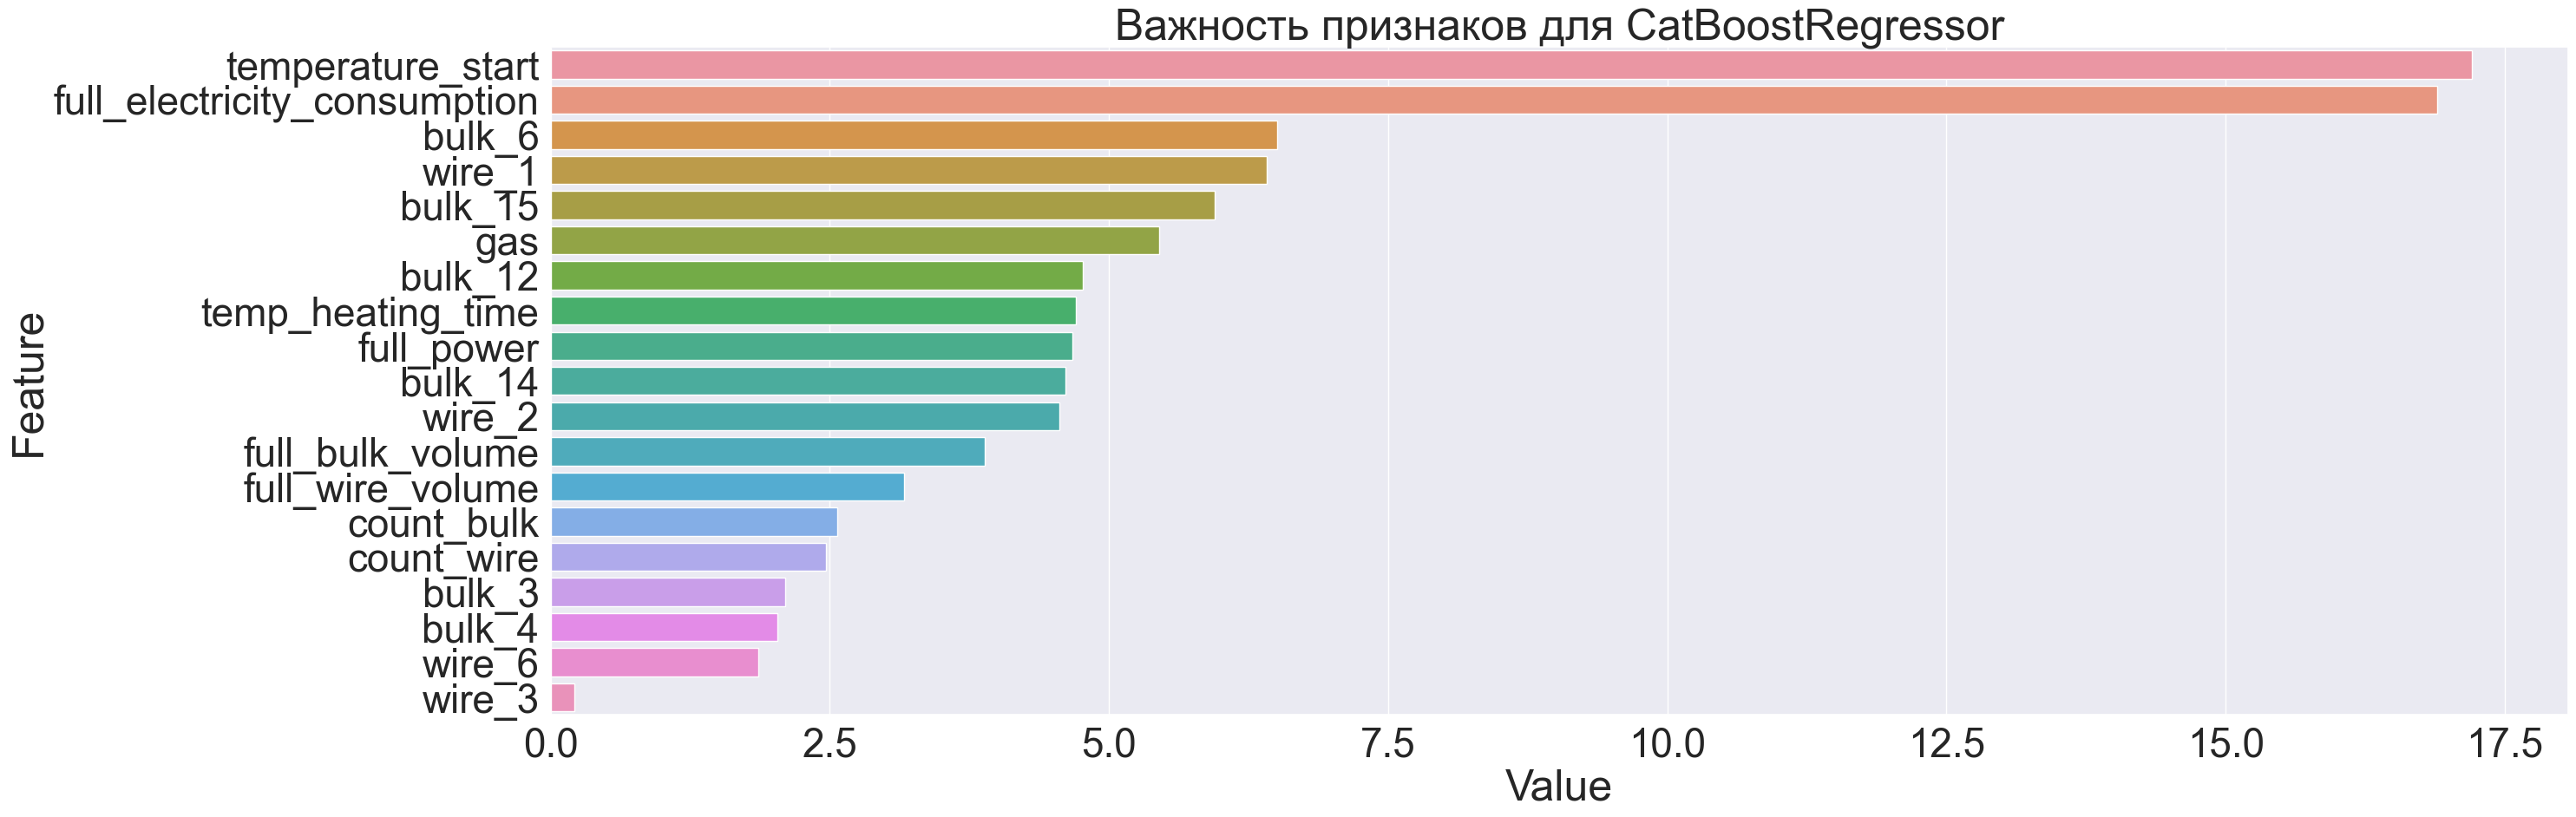

In [93]:
feature_imp = pd.DataFrame({'Value': cb_best_estimator[-1].feature_importances_, 'Feature': features.columns})
plt.figure(figsize=(30, 10))
sns.set(font_scale=3)
sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Важность признаков для CatBoostRegressor')

Самыми важными для модели оказались данные о потраченном на весь процесс нагрева стали количестве электричества и первоначальной температуре нагрева.
Все оставшиеся в датасете данные, за исключением проволочных добавок номер 3 и 6, которых достаточно немного использовалось в технологическом процессе, имеют вес и важность, а значит данные для модели подготовлены корректно.

### Итог:
**Цель исследования достигнута, лучшая модель, отобранная методом кросс-валидации на тестовых данных показала метрику MAE < 6.8**

Был проведен разведывательный и исследовательский анализ данных, в результате которых в данных были выявлены выбросы и пропуски, изучено распределение данных, сформулированы дополнительные вопросы к заказчику исследования. В ходе работы были выделены признаки для обучения модели, кроме того, на основе предоставленных данных были сгенерированы синтетические признаки, оказавшиеся значительное влияние на обучение модели.

Было проведено обучение моделей:
- LinearRegression;
- DecisionTreeRegressor;
- RandomForestRegressor;
- CatBoostRegressor;
- LGBMRegressor;
- DummyRegressor.

Проведена проверка моделей на адекватность путем сравнения с предсказанием костантной модели, валидация проводилась методом кросс-валидации с пятью фолдами.

Наилучший результат метрики MAE показала модель `CatBoost` с параметрами `iterations: 250, learning_rate: 0.1`, эта же модель была протестирована на тестовых данных. MAE на тестовой выборке составила 6.51 тем самым, цель исследования достигнута.

В целях увеличения точности прогнозов вероятно следует отсекать данные о добавленных сыпучих присадок номер 1, 2, 5, 7, 8, 9, 10, 11 и 13 и проволочных материалах под номерами 3, 4, 5, 6, 7, 8 и 9, замерах мощности нагрева, полученных хронологически после замерения конечной температуры.

Можно заметить большое количество пропусков в замерах за последний период в данных - проверить оборудование и ПО, которые отвечают за сбор статистики. Так же для более качественного предсказания было бы полезно получить данные о большем количестве партий.


### Выводы по работе с моделями и план следующего шага:

**Выводы:** в ходе исследования различных моделей машинного обучения была проделана следующая работа:
- созданы функции для оценки качества моделей;
- с помощью StandardScaler данные приведены к одинаковому масштабу;
- создано предсказания модели LinearRegressor;
- создано предсказания модели RandomForestRegressor;
- создано предсказания модели CatBoostRegressor;
- создано предсказания модели LGBMRegressor;
- создано предсказания модели DummyRegressor;
- проведено сравнение работы моделей и выбрана лучшая;
- подготовлена выборка важных признаков для полученной модели машинного обучения;
- проведен анализ работы лучшей модели на тестовых данных.

Дальнейшая работа с отчетом о проделанной работе будет включать в себя:
- краткое описание проделанной работы в ходе выполнения текущего задания;
- подведение итогов по проделанной работе.

## Шаг 4. Общий вывод <a class="anchor" id="section4"></a>

### Какие пункты плана были выполнены, а какие — нет. Почему?

#### Шаг 1. Знакомство с данными
На этом шаге была выполнена загрузка необходимых библиотек, проверка их наличия.
Так же был произведен разведочный анализ данных, в ходе которого были:
- оценены пропуски в полученных от заказчика таблицах,
- проверены данные на наличие явных дубликатов,
- составлены планы по предобработке для каждого датасета.

#### Шаг 2. Исследовательский анализ и предобработка данных
На этом шаге были выполнены следующие действия:
- предобработка данных:
    - работа с ошибками в данных - были выявлены и исключены из датасета строки содержащие данные нарушающие поставленные заказчиком технологические рамки (партии с показателями отрицательной мощности, температуры стали ниже 1500 градусов и полностью совпадающими начальными и финальными температурами нагрева);
    - работа с аномалиями в данных - было выявлено небольшое количество выбросов в данных, большинство из них не потребовало дополнительной обработки ввиду их небольшого количества;
    - обработка пропусков в данных - пропуски в столбцах, содержащих информацию о добавлении сыпучих и проволочных материалов были заполнены нулевыми значениями, т.к. в процессе уточнения технического задания стало известно, что пропуск означает отсутствие подачи материалов в сплав
    - создание синтетических признаков при необходимости - было рассчитано время нагрева и количество нагревов, так же на основании признаков активной и реактивной мощностей были рассчитаны признаки полной мощности и потребления электроэнергии каждой итерации, потребления электроэнергии каждой партии, общие объемы и количество добавлений сыпучих и проволочных материалов;
    - удаление данных непригодных к обучению модели - были удалены признаки содержащие пренебрежительно мало данных о добавленных сыпучих присадках номер 1, 2, 5, 7, 8, 9, 10, 11 и 13 и проволочных материалах под номерами 4, 5, 7, 8 и 9 а так же признаки о времени работы электродов и количестве итераций с их применением;
- формирование итогового датасета:
    - объединение данных в одну таблицу по полю key - данные были объединены в итоговый датафрейм методом inner, с полем 'key' установленным в качестве индекса;
- получившиеся данные прошли проверку на мультиколлинеарность;
- определение важных для модели и целевого признаков:
    - заказчиком был определен целевой признак для обучения модели - последняя температура нагрева;
    - данные были разделены на таблицу, содержащую только целевой признак, и таблицу, содержащую остальные полученные признаки, которые и были в дальнейшем использованы для обучения различных моделей машинного обучения;
- определение тестовой и тренировочной выборок по требованию заказчика в соотношении 25:75.

#### Шаг 3. Работа с моделями
В ходе выполнения этого шага были сделаны следующие действия:
- созданы функция оценки качества моделей и соответствия требованиям заказчика и функция поиска лучшей модели с помощью подбора гиперпараметров;
- создание предсказания с помощью нескольких моделей:
    - LinearRegressor;
    - RandomForestRegressor;
    - CatBoostRegressor;
    - LGBMRegressor;
    - DummyRegressor;
- сравнение работы моделей при помощи кросс-валидации и выбор лучшей;
- проверка адекватности модели при помощи константной модели была проведена с использованием DummyRegressor;
- анализ работы лучшей модели на тестовых данных;
- анализ важности переданных в модель данных и оценка предобработки;
- подведение итогов проделанной работы.

Таким образом, можно заключить, что все пункты плана были выполнены

### Какие трудности возникли и как вы их преодолели?
В ходе работы возникли следующие моменты, потребовавшие серьезной доработки:
- большое количество пропусков в данных о подаче сыпучих материалов и проволоки - получено разъяснение, пропуски заполнены нулевыми значениями;
- наличие выбросов в каждой характеристике - получено разъяснение, в большинстве случаев решено оставить без изменений;
- отсутствие данных - получены разъяснения, созданы синтетические характеристики.

### Какие ключевые шаги в решении задачи вы выделили?
Основные шаги в ходе выполнения данной работы:
- Шаг 1. Знакомство с данными;
- Шаг 2. Исследовательский анализ и предобработка данных
    - предобработка данных;
    - формирование итогового датасета;
- Шаг 3. Работа с моделями
    - создание предсказания с помощью нескольких моделей;
    - сравнение работы моделей при помощи кросс-валидации и выбор лучшей;
    - анализ работы лучшей модели на тестовых данных.

### Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?
Были использованы признаки содержащие информацию:
- `bulk_3` - информация об объеме добавленных сыпучих материалов под номером 3;
- `bulk_4` - информация об объеме добавленных сыпучих материалов под номером 4;
- `bulk_6` - информация об объеме добавленных сыпучих материалов под номером 6;
- `bulk_12` - информация об объеме добавленных сыпучих материалов под номером 12;
- `bulk_14` - информация об объеме добавленных сыпучих материалов под номером 14;
- `bulk_15` - информация об объеме добавленных сыпучих материалов под номером 15;
- `count_bulk` - информация о количестве различных добавленных сыпучих материалов;
- `count_wire` - информация о количестве различных добавленных проволочных материалов;
- `full_bulk_volume` - информация о полном объеме добавленных сыпучих материалов;
- `full_electricity_consumption` - информация о полном затраченном количестве электоэнергии на партию;
- `full_power` - информация о полной затраченной мощности электоэнергии на партию;
- `full_wire_volume` - информация о полном объеме добавленных проволочных материалов;
- `gas` - информация о полном объеме добавленного инертного газа;
- `temp_heating_time` - информация о полном времени, затраченном на нагрев партии;
- `temperature_start` - информация о температуре первого нагрева партии;
- `wire_1` - информация об объеме добавленных проволочных материалов под номером 1;
- `wire_2` - информация об объеме добавленных проволочных материалов под номером 2;
- `wire_3` - информация об объеме добавленных проволочных материалов под номером 3;
- `wire_6` - информация об объеме добавленных проволочных материалов под номером 6.

Из изначальных датасетов были получены признаки:
- `bulk_3`, `bulk_4`, `bulk_6`, `bulk_12`, `bulk_14`, `bulk_15` - информация об объеме добавленных сыпучих материалов под разными номерами, остальные сыпучие материалы были исключены ввиду их малого объема в предоставленных данных и малозначимости для технологического процесса;
- `gas` - информация о полном объеме добавленного инертного газа;
- `temperature_start` - информация о температуре первого нагрева партии;
- `wire_1`, `wire_2`, `wire_3`, `wire_6` - информация об объеме добавленных проволочных материалов под разными номерами, остальные сыпучие материалы были исключены ввиду их малого объема в предоставленных данных и малозначимости для технологического процесса.

Во время предобработки были получены следующие признаки:
- `count_bulk` - информация о количестве различных добавленных сыпучих материалов, полученная как расчет количества добавлений различных сыпучих материалов; 
- `count_wire` - информация о количестве различных добавленных проволочных материалов, полученная как расчет количества добавлений проволочных материалов;
- `full_bulk_volume` - информация о полном объеме добавленных сыпучих материалов, полученная как сумма всех добавленных сыпучих материалов;
- `full_electricity_consumption` - информация о полном затраченном количестве электоэнергии на партию, рассчитаная как сумма произведений полной мощности на время нагрева в каждой итерации; 
- `full_power` - информация о полной затраченной мощности электоэнергии на партию, полученная как $S = \sqrt{P^{2}+Q^{2}}$, где P — активная , Q — реактивная мощности, известные из изначальных датасетов; 
- `full_wire_volume` - информация о полном объеме добавленных проволочных материалов, полученная как сумма всех добавленных проволочных материалов,
- `temp_heating_time` - информация о полном времени, затраченном на нагрев партии, полученная как сумма разниц между началом и концом нагрева в каждой итерации.



### Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?
Лучшая модель CatBoostRegressor c гиперпараметрами: {'iterations': 200, 'learning_rate': 0.1}, MAE на тестовой выборке составила 6.511743.